## nn 作って plasiticc で活かしたい
やること
 * 基本的な mlp 作成　& 性能調査
 * cnn 使った band 間の情報抽出

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable #自動微分用

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import pandas as pd
from scipy.special import erfinv

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler
import lightgbm

from logging import getLogger
from tqdm import tqdm_notebook as tqdm
import argparse
import datetime
import random
from itertools import chain
import pickle
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

import gc
import sys
from multiprocessing import Pool
sys.path.append('../')

from tools.my_logging import logInit
from tools.feature_tools import feature_engineering
from tools.objective_function import weighted_multi_logloss, lgb_multi_weighted_logloss, wloss_objective, wloss_metric, softmax, calc_team_score
from tools.model_io import save_models, load_models
from tools.fold_resampling import get_fold_resampling_dict

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
NTHREAD = 62
random.seed(71)
np.random.seed(42)
torch.manual_seed(71)
%load_ext autoreload
%autoreload 2

## nn の作成開始
まずは　mlp から。
 * ネットワーク構造、batchnorm の有無、drop out の値を　configurable に
 * cnn との連携を意識
 * 

In [3]:
class plasticcNet(nn.Module):
    def __init__(self, input_unit_num, mlp_unit_nums, band_cnn_idxes=None,
                init_do_rate=0., middle_do_rate=0.5, last_do_rate=0.25):
        super(plasticcNet, self).__init__()
        self.activation = torch.nn.ELU()
        self.cnn_activation = torch.nn.ELU()
        self.cnn_dropout = torch.nn.Dropout(p=0.2)
        self.cnn_dropout2 = torch.nn.Dropout(p=0.2)
        self.band_cnn_idxes = band_cnn_idxes
        self.init_do_rate = init_do_rate
        self.middle_do_rate = middle_do_rate
        self.last_do_rate = last_do_rate
         
        # band 軽特徴量間の幾何的構造に基づく関係性を捉える cnn 
        # 1st では poolig せず、second で　pooling する？
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=1)
        self.band_conv_nets1 = nn.ModuleList()
        self.band_conv_nets2 = nn.ModuleList()
        self.band_batch_norm1 = nn.ModuleList()
        self.band_batch_norm2 = nn.ModuleList()
        #self.band_dropout1 = nn.ModuleList()
        #self.band_dropout2 = nn.ModuleList()
        if self.band_cnn_idxes:
            for band_cnn_idx in band_cnn_idxes:
                self.band_conv_nets1.append(
                    nn.Conv1d(
                        in_channels=1,
                        out_channels=1,
                        kernel_size=4,
                        stride=1)
                )
                #self.band_batch_norm1.append(nn.LayerNorm(6))
                self.band_batch_norm1.append(nn.BatchNorm1d(1))
                #self.band_dropout1.append()
                self.band_conv_nets2.append(
                    nn.Conv1d(
                        in_channels=1,
                        out_channels=1,
                        kernel_size=3,
                        stride=1)
                )
                #self.band_batch_norm2.append(nn.LayerNorm(4))
                self.band_batch_norm2.append(nn.BatchNorm1d(1))
                #self.band_dropout2.append()
            None
       
        # mlp を組む
        # 一層目の unit num を作る
        if self.band_cnn_idxes:
            self.unpacked_band_cnn_idxes = list(chain.from_iterable(self.band_cnn_idxes))
            #past_unit_num = input_unit_num + len(self.unpacked_band_cnn_idxes) // 6 * 4 - len(self.unpacked_band_cnn_idxes) # only 1 layer
            #past_unit_num = input_unit_num + len(self.unpacked_band_cnn_idxes) // 6 * 6 - len(self.unpacked_band_cnn_idxes) # only 1 layer
            self.cnn_out_unit_num = len(self.unpacked_band_cnn_idxes) // 6 * 4
            self.cnn_bn = nn.LayerNorm(self.cnn_out_unit_num)
            #self.cnn_bn = nn.BatchNorm1d(self.cnn_out_unit_num)
            past_unit_num = input_unit_num + self.cnn_out_unit_num - len(self.unpacked_band_cnn_idxes) # w/o pooling
            #past_unit_num = input_unit_num + len(self.unpacked_band_cnn_idxes) // 6 * 3 - len(self.unpacked_band_cnn_idxes)
        else:
            past_unit_num = input_unit_num
        self.dense_nets = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for i, mlp_unit_num in enumerate(mlp_unit_nums):
            self.dense_nets.append(nn.Linear(past_unit_num, mlp_unit_num))
            self.batch_norms.append(nn.BatchNorm1d(mlp_unit_num))
            if i == 0:
                p = self.init_do_rate
            elif i == len(mlp_unit_nums) - 1:
                p = self.last_do_rate
            else:
                p = self.middle_do_rate
            self.dropouts.append(nn.Dropout(p=p))
            past_unit_num = mlp_unit_num
            
    def forward(self, x):
        batch_size = x.shape[0]
        x_cnns = []
        if len(self.band_conv_nets1) > 0:
            for zipped in zip(self.band_cnn_idxes, 
                            self.band_conv_nets1, self.band_batch_norm1, 
                            self.band_conv_nets2, self.band_batch_norm2):
                band_cnn_idx, band_conv_net1, band_batch_norm1, band_conv_net2, band_batch_norm2 = zipped
                x_cnn = x[:, band_cnn_idx]
                x_cnn = torch.cat([x_cnn, x_cnn[:,:3]], dim=1) # mod
                x_cnn = x_cnn.view(batch_size, 1, -1) 
                x_cnn = band_conv_net1(x_cnn) 
                x_cnn = self.cnn_activation(x_cnn)
                x_cnn = band_batch_norm1(x_cnn)
                x_cnn = self.cnn_dropout(x_cnn)
                #x_cnn = self.maxpool1(x_cnn)
                x_cnn = band_conv_net2(x_cnn) 
                x_cnn = self.cnn_activation(x_cnn)
                #x_cnn = band_batch_norm2(x_cnn)
                #x_cnn = self.cnn_dropout(x_cnn)
                #x_cnn = self.maxpool2(x_cnn)
                x_cnns.append(x_cnn)

            x_cnns = torch.cat(x_cnns, dim=1).view(batch_size, -1) # concat して channel を押しつぶす
            x_cnns = self.cnn_bn(x_cnns)
            x_cnns = self.cnn_dropout2(x_cnns)
            x = np.delete(x, self.unpacked_band_cnn_idxes, axis=1) # drop used idxes  self.unpacked....
            x = torch.cat([x, x_cnns], dim=1) 
        else:
            x = x
        for i, nets in enumerate(list(zip(self.dense_nets, self.batch_norms, self.dropouts))):
            dense_net, batch_norm, dropout = nets
            if i < len(self.dense_nets) - 1:
                x = dropout(x)
                x = dense_net(x)
                x = self.activation(x)
                x = batch_norm(x)
            else:
                x = dropout(x)
                x =  dense_net(x)
                #x = batch_norm(x)
                #x = dropout(x)
        return x

#### とりあえずネットワークはできたので loss を定義して学習させてみる

In [4]:
# feature を作る
#logger = getLogger(__name__)
#logInit(logger, log_dir='../log/', log_filename='notebook.log')

#training_set_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set.csv')
#training_set_metadata_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set_metadata.csv')
#train_df = feature_engineering(
#        training_set_df,
#        training_set_metadata_df,
#        nthread=NTHREAD,
#        logger=logger)

In [63]:
FEATURES_TO_USE = [
#        'hostgal_photoz',
        'hostgal_photoz_err',
        'distmod',
        'lumi_dist',
        'flux_min',
        'flux_max',
        'flux_mean',
        'flux_median',
        'flux_std',
        'flux_var',
        'flux_skew',
        'flux_count',
        'flux_kurtosis',
        'corrected_flux_min',
        'corrected_flux_max',
        'corrected_flux_mean',
        'corrected_flux_median',
        'corrected_flux_std',
        'corrected_flux_var',
        'corrected_flux_skew',
        'flux_err_min',
        'flux_err_max',
        'flux_err_mean',
        'flux_err_median',
        'flux_err_std',
        'flux_err_var',
        'flux_err_skew',
        'flux_err_kurtosis',
        'flux_ratio_to_flux_err_min',
        'flux_ratio_to_flux_err_max',
        'detected_mean',
        'flux_ratio_sq_skew',
        'flux_ratio_sq_mean',
        'flux_ratio_sq_kurtosis',
        'flux_by_flux_ratio_sq_sum',
        'flux_by_flux_ratio_sq_skew',
        'corrected_flux_ratio_sq_sum',
        'corrected_flux_ratio_sq_skew',
        'corrected_flux_by_flux_ratio_sq_sum',
        'corrected_flux_by_flux_ratio_sq_skew',
        'std_upper_mjd_get_max_min_diff',
        'std_upper_mjd_var',
        'std_upper_mjd_skew',
        'std_upper_flux_count',
        'std_upper_flux_min',
        'detected_mjd_get_max_min_diff',
        'detected_mjd_skew',
        'band-0_wmean',
        'band-0_normed_std',
        'band-0_normed_amp',
        'band-0_normed_mad',
        'band-0_beyond_1std',
        'band-0_flux_var',
        'band-0_flux_skew',
        'band-0_flux_kurtosis',
        'band-0_flux_quantile10',
        'band-0_flux_quantile25',
        'band-0_flux_quantile75',
        'band-0_flux_quantile90',
        'band-0_flux_quantile2575_range',
        'band-0_flux_quantile1090_range',
        'band-0_normed_flux_diff_mean',
        'band-0_detected_mean',
        'band-0_flux_ratio_sq_sum',
        'band-0_flux_ratio_sq_skew',
        'band-0_flux_by_flux_ratio_sq_sum',
        'band-0_flux_by_flux_ratio_sq_skew',
        'band-0_flux_get_max_min_diff',
        'band-0_std_upper_mjd_get_max_min_diff',
        'band-0_std_upper_mjd_var',
        'band-0_std_upper_mjd_skew',
        'band-0_std_upper_mjd_diff_mean',
        'band-0_std_upper_flux_count',
#        'band-0_std_upper_flux_count_ratio',
        'band-0_std_upper_flux_diff_mean',
        'band-1_wmean',
        'band-1_normed_std',
        'band-1_normed_amp',
        'band-1_normed_mad',
        'band-1_beyond_1std',
        'band-1_flux_var',
        'band-1_flux_skew',
        'band-1_flux_kurtosis',
        'band-1_flux_quantile10',
        'band-1_flux_quantile25',
        'band-1_flux_quantile75',
        'band-1_flux_quantile90',
        'band-1_flux_quantile2575_range',
        'band-1_flux_quantile1090_range',
        'band-1_normed_flux_diff_mean',
        'band-1_detected_mean',
        'band-1_flux_ratio_sq_sum',
        'band-1_flux_ratio_sq_skew',
        'band-1_flux_by_flux_ratio_sq_sum',
        'band-1_flux_by_flux_ratio_sq_skew',
        'band-1_flux_get_max_min_diff',
        'band-1_std_upper_mjd_get_max_min_diff',
        'band-1_std_upper_mjd_var',
        'band-1_std_upper_mjd_skew',
        'band-1_std_upper_mjd_diff_mean',
        'band-1_std_upper_flux_count',
#        'band-1_std_upper_flux_count_ratio',
        'band-1_std_upper_flux_diff_mean',
        'band-2_wmean',
        'band-2_normed_std',
        'band-2_normed_amp',
        'band-2_normed_mad',
        'band-2_beyond_1std',
        'band-2_flux_var',
        'band-2_flux_skew',
        'band-2_flux_kurtosis',
        'band-2_flux_quantile10',
        'band-2_flux_quantile25',
        'band-2_flux_quantile75',
        'band-2_flux_quantile90',
        'band-2_flux_quantile2575_range',
        'band-2_flux_quantile1090_range',
        'band-2_normed_flux_diff_mean',
        'band-2_detected_mean',
        'band-2_flux_ratio_sq_sum',
        'band-2_flux_ratio_sq_skew',
        'band-2_flux_by_flux_ratio_sq_sum',
        'band-2_flux_by_flux_ratio_sq_skew',
        'band-2_flux_get_max_min_diff',
        'band-2_std_upper_mjd_get_max_min_diff',
        'band-2_std_upper_mjd_var',
        'band-2_std_upper_mjd_skew',
        'band-2_std_upper_mjd_diff_mean',
        'band-2_std_upper_flux_count',
#        'band-2_std_upper_flux_count_ratio',
        'band-2_std_upper_flux_diff_mean',
        'band-3_wmean',
        'band-3_normed_std',
        'band-3_normed_amp',
        'band-3_normed_mad',
        'band-3_beyond_1std',
        'band-3_flux_var',
        'band-3_flux_skew',
        'band-3_flux_kurtosis',
        'band-3_flux_quantile10',
        'band-3_flux_quantile25',
        'band-3_flux_quantile75',
        'band-3_flux_quantile90',
        'band-3_flux_quantile2575_range',
        'band-3_flux_quantile1090_range',
        'band-3_normed_flux_diff_mean',
        'band-3_detected_mean',
        'band-3_flux_ratio_sq_sum',
        'band-3_flux_ratio_sq_skew',
        'band-3_flux_by_flux_ratio_sq_sum',
        'band-3_flux_by_flux_ratio_sq_skew',
        'band-3_flux_get_max_min_diff',
        'band-3_std_upper_mjd_get_max_min_diff',
        'band-3_std_upper_mjd_var',
        'band-3_std_upper_mjd_skew',
        'band-3_std_upper_mjd_diff_mean',
        'band-3_std_upper_flux_count',
#        'band-3_std_upper_flux_count_ratio',
        'band-3_std_upper_flux_diff_mean',
        'band-4_wmean',
        'band-4_normed_std',
        'band-4_normed_amp',
        'band-4_normed_mad',
        'band-4_beyond_1std',
        'band-4_flux_var',
        'band-4_flux_skew',
        'band-4_flux_kurtosis',
        'band-4_flux_quantile10',
        'band-4_flux_quantile25',
        'band-4_flux_quantile75',
        'band-4_flux_quantile90',
        'band-4_flux_quantile2575_range',
        'band-4_flux_quantile1090_range',
        'band-4_normed_flux_diff_mean',
        'band-4_detected_mean',
        'band-4_flux_ratio_sq_sum',
        'band-4_flux_ratio_sq_skew',
        'band-4_flux_by_flux_ratio_sq_sum',
        'band-4_flux_by_flux_ratio_sq_skew',
        'band-4_flux_get_max_min_diff',
        'band-4_std_upper_mjd_get_max_min_diff',
        'band-4_std_upper_mjd_var',
        'band-4_std_upper_mjd_skew',
        'band-4_std_upper_mjd_diff_mean',
        'band-4_std_upper_flux_count',
#        'band-4_std_upper_flux_count_ratio',
        'band-4_std_upper_flux_diff_mean',
        'band-5_wmean',
        'band-5_normed_std',
        'band-5_normed_amp',
        'band-5_normed_mad',
        'band-5_beyond_1std',
        'band-5_flux_var',
        'band-5_flux_skew',
        'band-5_flux_kurtosis',
        'band-5_flux_quantile10',
        'band-5_flux_quantile25',
        'band-5_flux_quantile75',
        'band-5_flux_quantile90',
        'band-5_flux_quantile2575_range',
        'band-5_flux_quantile1090_range',
        'band-5_normed_flux_diff_mean',
        'band-5_detected_mean',
        'band-5_flux_ratio_sq_sum',
        'band-5_flux_ratio_sq_skew',
        'band-5_flux_by_flux_ratio_sq_sum',
        'band-5_flux_by_flux_ratio_sq_skew',
        'band-5_flux_get_max_min_diff',
        'band-5_std_upper_mjd_get_max_min_diff',
        'band-5_std_upper_mjd_var',
        'band-5_std_upper_mjd_skew',
        'band-5_std_upper_mjd_diff_mean',
        'band-5_std_upper_flux_count',
#        'band-5_std_upper_flux_count_ratio',
        'band-5_std_upper_flux_diff_mean',
        '0_minus_1_wmean',
        '0_minus_1_std',
        '0_minus_1_amp',
        '1_minus_2_wmean',
        '1_minus_2_std',
        '1_minus_2_amp',
        '2_minus_3_wmean',
        '2_minus_3_std',
        '2_minus_3_amp',
        '3_minus_4_wmean',
        '3_minus_4_std',
        '3_minus_4_amp',
        '4_minus_5_wmean',
        '4_minus_5_std',
        '4_minus_5_amp',
        '5_minus_0_wmean',
        '5_minus_0_std',
        '5_minus_0_amp',
        'flux_diff',
        'flux_dif2',
        'flux_w_mean',
        'flux_dif3',
        'corrected_flux_diff',
        'corrected_flux_dif2',
        'corrected_flux_w_mean',
        'corrected_flux_dif3',
        'std_upper_rat',
        'band-0_flux_max_ratio_to_the_max',
        'band-1_flux_max_ratio_to_the_max',
        'band-2_flux_max_ratio_to_the_max',
        'band-3_flux_max_ratio_to_the_max',
        'band-4_flux_max_ratio_to_the_max',
        'band-5_flux_max_ratio_to_the_max',
        'passband_flux_min_var',
        'passband_flux_means_var',
        'passband_flux_counts_var',
        'passband_detected_means_var',
        'band_flux_diff_max',
        'band_flux_diff_min',
        'band_flux_diff_diff',
        'band_flux_diff_diff_rat',
        'band_flux_max_min_rat',
        '0__length',
        '0__longest_strike_above_mean',
        '0__longest_strike_below_mean',
        '0__mean_abs_change',
        '0__mean_change',
        '1__length',
        '1__longest_strike_above_mean',
        '1__longest_strike_below_mean',
        '1__mean_abs_change',
        '1__mean_change',
        '2__length',
        '2__longest_strike_above_mean',
        '2__longest_strike_below_mean',
        '2__mean_abs_change',
        '2__mean_change',
        '3__length',
        '3__longest_strike_above_mean',
        '3__longest_strike_below_mean',
        '3__mean_abs_change',
        '3__mean_change',
        '4__length',
        '4__longest_strike_above_mean',
        '4__longest_strike_below_mean',
        '4__mean_abs_change',
        '4__mean_change',
        '5__length',
        '5__longest_strike_above_mean',
        '5__longest_strike_below_mean',
        '5__mean_abs_change',
        '5__mean_change',
        'internal',
        'c90_z_z1',
        'c90_y_z1',
        'c52_y_z1',
        'c67_g_z2',
        'c67_i_z2',
        'c67_y_z2',
        'c52_r_z3',
        'c42_i_z4',
        'c42_z_z4',
###        'band-0_detected_mjd_get_max_min_diff', # $B$3$l7O$O(B cv $B",(B lb $B"-(B
#        'band-0_detected_mjd_var',
#        'band-0_detected_mjd_skew',
#        'band-0_detected_mjd_diff_mean',
###        'band-1_detected_mjd_get_max_min_diff',
#        'band-1_detected_mjd_var',
#        'band-1_detected_mjd_skew',
#        'band-1_detected_mjd_diff_mean',
###        'band-2_detected_mjd_get_max_min_diff',
#        'band-2_detected_mjd_var',
#        'band-2_detected_mjd_skew',
#        'band-2_detected_mjd_diff_mean',
###        'band-3_detected_mjd_get_max_min_diff',
#        'band-3_detected_mjd_var',
#        'band-3_detected_mjd_skew',
#        'band-3_detected_mjd_diff_mean',
###        'band-4_detected_mjd_get_max_min_diff',
#        'band-4_detected_mjd_var',
#        'band-4_detected_mjd_skew',
#        'band-4_detected_mjd_diff_mean',
###        'band-5_detected_mjd_get_max_min_diff',
#        'band-5_detected_mjd_var',
#        'band-5_detected_mjd_skew',
#        'band-5_detected_mjd_diff_mean'
#        '0_minus_1_dmgmmd',
#        '1_minus_2_dmgmmd',
#        '2_minus_3_dmgmmd',
#        '3_minus_4_dmgmmd',
#        '4_minus_5_dmgmmd',
#        '5_minus_0_dmgmmd',
#        'std_lower_mjd_get_max_min_diff',
#        'std_lower_mjd_var',
#        'std_lower_mjd_skew',
#        'std_lower_flux_count',
#        'std_lower_flux_max'
#        '0_minus_1_skew',
#        '1_minus_2_skew',
#        '2_minus_3_skew',
#        '3_minus_4_skew',
#        '4_minus_5_skew',
#        '5_minus_0_skew',
#        '0_minus_1_kurt',
#        '1_minus_2_kurt',
#        '2_minus_3_kurt',
#        '3_minus_4_kurt',
#        '4_minus_5_kurt',
#        '5_minus_0_kurt',
        '0_minus_1_q2575_rng',
        '1_minus_2_q2575_rng',
        '2_minus_3_q2575_rng',
        '3_minus_4_q2575_rng',
        '4_minus_5_q2575_rng',
        '5_minus_0_q2575_rng',
        'band-0_std_upper_flux_quantile10',
        'band-1_std_upper_flux_quantile10',
        'band-2_std_upper_flux_quantile10',
        'band-3_std_upper_flux_quantile10',
        'band-4_std_upper_flux_quantile10',
        'band-5_std_upper_flux_quantile10',
#        'band-0_std_upper_flux_quantile25',
#        'band-1_std_upper_flux_quantile25',
#        'band-2_std_upper_flux_quantile25',
#        'band-3_std_upper_flux_quantile25',
#        'band-4_std_upper_flux_quantile25',
#        'band-5_std_upper_flux_quantile25',
#        'band-0_std_upper_flux_quantile75',
#        'band-1_std_upper_flux_quantile75',
#        'band-2_std_upper_flux_quantile75',
#        'band-3_std_upper_flux_quantile75',
#        'band-4_std_upper_flux_quantile75',
#        'band-5_std_upper_flux_quantile75',
        'band-0_std_upper_flux_quantile90',
        'band-1_std_upper_flux_quantile90',
        'band-2_std_upper_flux_quantile90',
        'band-3_std_upper_flux_quantile90',
        'band-4_std_upper_flux_quantile90',
        'band-5_std_upper_flux_quantile90',
#        'band-0_std_upper_flux_quantile2575_range',
#        'band-1_std_upper_flux_quantile2575_range',
#        'band-2_std_upper_flux_quantile2575_range',
#        'band-3_std_upper_flux_quantile2575_range',
#        'band-4_std_upper_flux_quantile2575_range',
#        'band-5_std_upper_flux_quantile2575_range',
#        'band-0_std_upper_flux_quantile1090_range',
#        'band-1_std_upper_flux_quantile1090_range',
#        'band-2_std_upper_flux_quantile1090_range',
#        'band-3_std_upper_flux_quantile1090_range',
#        'band-4_std_upper_flux_quantile1090_range',
#        'band-5_std_upper_flux_quantile1090_range',
#        'band-0_flux_max',
#        'band-1_flux_max',
#        'band-2_flux_max',
#        'band-3_flux_max',
#        'band-4_flux_max',
#        'band-5_flux_max',
        '0_minus_1_max',
        '1_minus_2_max',
        '2_minus_3_max',
        '3_minus_4_max',
        '4_minus_5_max',
        '5_minus_0_max',
#        'abs_magnitude_min',
#        'abs_magnitude_max',
#        'abs_magnitude_mean',
#        'abs_magnitude_median',
#        'abs_magnitude_std',
#        'abs_magnitude_var',
#        'abs_magnitude_skew',
#        'abs_magnitude_kurtosis',
#####        'luminosity_max', 
#####        'peak-14-14_flux_mean',
#####        'peak-30-30_flux_mean',
#####        'peak-90-90_flux_mean',
#####        'peak-14-14_flux_kurtosis',
#####        'peak-30-30_flux_kurtosis',
#####        'peak-90-90_flux_kurtosis',
#####        'peak_kurt_14to30',
#        'peak_kurt_14to90',
#####        'peak_kurt_30to90',
#####        'peak-14-14_flux_skew',
#        'peak-30-30_flux_skew',
#        'peak-90-90_flux_skew',
#####        'peak_skew_14to30',
#        'peak_skew_14to90',
#        'peak_skew_30to90',
#####        'peak-0-14_flux_diff_var',
#####        'peak-0-30_flux_diff_var',
#####        'peak-0-90_flux_diff_var',
#        'peak-14-0_flux_diff_var',
#        'peak-30-0_flux_diff_var',
#        'peak-14-14_flux_get_max_min_diff',
#        'peak-30-30_flux_get_max_min_diff',
#        'peak-90-90_flux_get_max_min_diff',
#        'peak-30-30_luminosity_kurtosis',
#        'peak-14-14_detected_mean',
#        'peak-0-30_abs_magnitude_diff_var',
#        'peak-0-90_abs_magnitude_diff_var',
#        'peak-14-14_abs_magnitude_skew',
#####        'peak-30-30_abs_magnitude_skew',
#####        'peak-90-90_abs_magnitude_skew',
#        'peak-14-14_abs_magnitude_kurtosis',
#####        'peak-30-30_abs_magnitude_kurtosis',
#####        'peak-90-90_abs_magnitude_kurtosis',
#        'peak-14-14_flux_ratio_sq_sum',
#        'peak-30-30_flux_ratio_sq_sum',
#        'peak-90-90_flux_ratio_sq_sum',
#####        'ratsq-peak-14-14_flux_ratio_sq_skew',
#        'peak-30-30_flux_ratio_sq_skew',
#####        'ratsq-peak-90-90_flux_ratio_sq_skew',
#        'peak-14-14_flux_ratio_sq_kurtosis',
#        'peak-30-30_flux_ratio_sq_kurtosis',
#        'peak-90-90_flux_ratio_sq_kurtosis',
#        'peak-0-14_flux_ratio_sq_skew',
#        'peak-14-14_flux_ratio_sq_mean',
#        'peak-30-30_flux_ratio_sq_mean',
#        'peak-90-90_flux_ratio_sq_mean',
#        'peak-14-14_corrected_flux_by_flux_ratio_sq_skew',
#        'peak-30-30_corrected_flux_by_flux_ratio_sq_skew',
#        'band-0_flux_ratio_sq_get_max_min_diff',
#        'band-1_flux_ratio_sq_get_max_min_diff',
#        'band-2_flux_ratio_sq_get_max_min_diff',
#        'band-3_flux_ratio_sq_get_max_min_diff',
#        'band-4_flux_ratio_sq_get_max_min_diff',
#        'band-5_flux_ratio_sq_get_max_min_diff',
        '0_minus_1_ratsqmax',
        '1_minus_2_ratsqmax',
        '2_minus_3_ratsqmax',
        '3_minus_4_ratsqmax',
        '4_minus_5_ratsqmax',
        '5_minus_0_ratsqmax',
#        '0_minus_1_ratsqmax_log',
#        '1_minus_2_ratsqmax_log',
#        '2_minus_3_ratsqmax_log',
#        '3_minus_4_ratsqmax_log',
#        '4_minus_5_ratsqmax_log',
#        '5_minus_0_ratsqmax_log',
#        'band-0_flux_ratio_sq_max_ratio',
#        'band-1_flux_ratio_sq_max_ratio',
#        'band-2_flux_ratio_sq_max_ratio',
#        'band-3_flux_ratio_sq_max_ratio',
#        'band-4_flux_ratio_sq_max_ratio',
#        'band-5_flux_ratio_sq_max_ratio',
#        'flux_ratio_sq_max',
            'my_skew',
            'my_kurt',
            'mjd_diff_af_det1',
#            'mjd_diff_bf_det1',
            'mjd_diff_ab_sum',    
            'hostgal_photoz',    
]


CNN_FEATURES = [
        [f'band-{i}_wmean' for i in range(6)],
        [f'band-{i}_normed_std' for i in range(6)],
        [f'band-{i}_normed_amp' for i in range(6)],
        [f'band-{i}_normed_mad' for i in range(6)],
        [f'band-{i}_beyond_1std' for i in range(6)],
        [f'band-{i}_flux_var' for i in range(6)],
        [f'band-{i}_flux_skew' for i in range(6)],
        [f'band-{i}_flux_kurtosis' for i in range(6)],
        [f'band-{i}_flux_quantile10' for i in range(6)],
        [f'band-{i}_flux_quantile25' for i in range(6)],
        [f'band-{i}_flux_quantile75' for i in range(6)],
        [f'band-{i}_flux_quantile90' for i in range(6)],
        [f'band-{i}_flux_quantile2575_range' for i in range(6)],
        [f'band-{i}_flux_quantile1090_range' for i in range(6)],
        [f'band-{i}_normed_flux_diff_mean' for i in range(6)],
        [f'band-{i}_detected_mean' for i in range(6)],
        [f'band-{i}_flux_ratio_sq_sum' for i in range(6)],
        [f'band-{i}_flux_ratio_sq_skew' for i in range(6)],
        [f'band-{i}_flux_by_flux_ratio_sq_sum' for i in range(6)],
        [f'band-{i}_flux_by_flux_ratio_sq_skew' for i in range(6)],
        [f'band-{i}_flux_get_max_min_diff' for i in range(6)],
        [f'band-{i}_std_upper_mjd_get_max_min_diff' for i in range(6)],
        [f'band-{i}_std_upper_mjd_var' for i in range(6)],
        [f'band-{i}_std_upper_mjd_skew' for i in range(6)],
        [f'band-{i}_std_upper_mjd_diff_mean' for i in range(6)],
        [f'band-{i}_std_upper_flux_count' for i in range(6)],
        [f'band-{i}_std_upper_flux_diff_mean' for i in range(6)],
        [f'band-{i}_flux_max_ratio_to_the_max' for i in range(6)],
        [f'band-{i}_std_upper_flux_quantile10' for i in range(6)],
        [f'band-{i}_std_upper_flux_quantile90' for i in range(6)],
        [f'{i}_minus_{(i+1)%6}_wmean' for i in range(6)],
        [f'{i}_minus_{(i+1)%6}_std' for i in range(6)],
        [f'{i}_minus_{(i+1)%6}_amp' for i in range(6)],
        [f'{i}__length' for i in range(6)],
        [f'{i}__longest_strike_above_mean' for i in range(6)],
        [f'{i}__longest_strike_below_mean' for i in range(6)],
        [f'{i}__mean_abs_change' for i in range(6)],
        [f'{i}__mean_change' for i in range(6)],
        [f'{i}_minus_{(i+1)%6}_q2575_rng' for i in range(6)],
        [f'{i}_minus_{(i+1)%6}_max' for i in range(6)],
        [f'{i}_minus_{(i+1)%6}_ratsqmax' for i in range(6)],
]

In [64]:
imp_df = pd.read_csv('../importances/Booster_weight-multi-logloss-0.551369_2018-12-09-13-05-52_importance.csv')

In [65]:
FEATURES_TO_USE = [feat for feat in FEATURES_TO_USE if feat in set(imp_df.head(120).feature)] + ['hostgal_photoz']

In [66]:
%%time
train_df = pd.read_feather('../features/train/meta_features.ftr', nthreads=NTHREAD)

CPU times: user 2.69 s, sys: 936 ms, total: 3.62 s
Wall time: 168 ms


In [67]:
%%time
with open('../lcfit/LCfit_features_train_20181129.pkl', 'rb') as fin:
    train_df = train_df.merge(pickle.load(fin), on='object_id', how='left')

CPU times: user 1.67 s, sys: 4 ms, total: 1.68 s
Wall time: 1.68 s


In [9]:
%%time
test_df = pd.read_feather('../features/test/meta_features.ftr', nthreads=NTHREAD)

CPU times: user 1min 23s, sys: 1min 58s, total: 3min 21s
Wall time: 3min 24s


In [10]:
%%time
with open('../lcfit/LCfit_feature_test_v1_20181203.pkl', 'rb') as fin:
    _test_df = pickle.load(fin)
#test_df = test_df.merge(_test_df, on='object_id', how='left')
#del _test_df
gc.collect()

CPU times: user 220 ms, sys: 532 ms, total: 752 ms
Wall time: 748 ms


In [11]:
#%%time
#test_df = pd.concat([test_df[list(sorted(list(set(FEATURES_TO_USE) & set(test_df.columns.tolist()))))], _test_df.drop('object_id', axis=1)], axis=1)

In [11]:
%%time
test_df = test_df[list(sorted(list(set(FEATURES_TO_USE) & set(test_df.columns.tolist())))) + ['object_id']].merge(_test_df, on='object_id', how='left')

CPU times: user 6.56 s, sys: 10.5 s, total: 17.1 s
Wall time: 17 s


In [68]:
# inf の変換
train_df = train_df.replace(np.inf, np.nan)
train_df = train_df.replace(-np.inf, np.nan)
#train_df = train_df.fillna(train_df.mean())#.drop(null_df[null_df.null_rat != 0]['column'], axis=1)

In [13]:
# test df の　load, inf の変換
#test_df = pd.read_feather('../test_dfs/test_df_for_nn.fth')
test_df = test_df.replace(np.inf, np.nan)
test_df = test_df.replace(-np.inf, np.nan)
test_df

,0__mean_change,0_minus_1_amp,1__longest_strike_above_mean,1__mean_change,1_minus_2_max,1_minus_2_q2575_rng,1_minus_2_ratsqmax,1_minus_2_std,1_minus_2_wmean,2__longest_strike_above_mean,...,object_id,c90_z_z1,c90_y_z1,c52_y_z1,c67_g_z2,c67_i_z2,c67_y_z2,c52_r_z3,c42_i_z4,c42_z_z4
0,-0.034282,5.075317,6.0,0.059009,-1.124680,-2.833751,6.545295,-0.904106,-0.095024,14.0,...,13,9.390269,1.943906,2.993463,1.898032,11.232923,2.344784,6.132683,6.578410,9.933218
1,-0.013834,4.661672,5.0,-0.276351,-0.716988,0.133164,26.850117,0.056465,-0.050171,4.0,...,14,NaN,NaN,NaN,0.972816,1.197749,NaN,1.107778,1.070769,NaN
2,0.003316,-22.394442,7.0,-0.001739,-1.217069,0.712366,44.951951,0.149782,0.064331,7.0,...,17,NaN,NaN,NaN,1.361492,1.101139,NaN,1.270988,1.311761,NaN
3,-0.073262,227.437086,8.0,-0.005209,-0.108787,0.447291,-18.720006,-0.300102,NaN,5.0,...,23,0.737174,NaN,NaN,NaN,1.653800,NaN,1.146899,1.613232,0.852435
4,-0.019088,1.134959,5.0,-0.023135,-54.896332,-0.197334,-7470.834992,-8.760074,0.759370,5.0,...,34,5.367685,2.063274,1.488509,7.534384,20.952691,1.476331,61.873673,17.218760,6.591742
5,0.003286,-34.533708,5.0,0.073171,-12.536358,-0.219314,-262.900837,-1.572964,3.458243,9.0,...,35,1.500328,0.734977,1.075497,NaN,3.164535,0.975357,1.811993,3.462126,1.307392
6,0.031174,-111.098539,8.0,0.001090,0.162564,0.397122,-42.101224,-0.534626,1.402927,9.0,...,43,NaN,NaN,NaN,NaN,1.508438,NaN,0.930497,1.293318,NaN
7,0.021571,-137.534164,4.0,0.033203,-3.790406,0.059348,-94.719437,-1.058650,4.852230,6.0,...,50,NaN,NaN,NaN,NaN,NaN,NaN,1.419350,NaN,NaN
8,0.033995,58.850216,7.0,-0.062192,-6.553512,-0.223504,-56.722610,-0.866325,3.520108,6.0,...,60,1.260674,NaN,NaN,NaN,1.514927,NaN,1.231022,1.784987,1.186469
9,-0.012537,-0.915038,5.0,-0.144528,-6.018574,0.755650,-227.490982,-1.303065,1.803503,6.0,...,69,1.873220,1.030602,0.985040,NaN,1.318693,0.960344,1.300163,1.912828,1.838702


In [69]:
class GaussRankScaler():

    def __init__(self):
        self.epsilon = 0.001
        self.lower = -1 + self.epsilon
        self.upper = 1 - self.epsilon
        self.range = self.upper - self.lower
        
    def fit_transform(self, X):

        i = np.argsort(X, axis=0)
        j = np.argsort(i, axis=0)

        assert (j.min() == 0).all()
        assert (j.max() == len(j) - 1).all()

        j_range = len(j) - 1
        self.divider = j_range / self.range

        transformed = j / self.divider
        transformed = transformed - self.upper
        transformed = erfinv(transformed)

        return transformed
    
def continuousNormalization(target_df, scaler):
    for column in tqdm(target_df.columns.values):
        # minmax normalization for continuous data
        if target_df[column].dtype != 'object' and column != 'target':
            if target_df[column].max() > 0:
                target_df[column] = \
                    scaler.fit_transform(target_df[column])
    return target_df    

def continuousNormalizationForArray(target_array, scaler):
    for idx in tqdm(range(target_array.shape[1])):
        target_array[:,idx] = scaler.fit_transform(target_array[:,idx])
        # minmax normalization for continuous data
    return target_array
    
#scaler = GaussRankScaler()    
#train_df = continuousNormalization(train_df, scaler)
    
#scaler = GaussRankScaler()    
#train_df = continuousNormalization(train_df, scaler)

class MKRankGaussScalar(object):
    """usage: 
    rgs = RankGaussScalar()
    rgs.fit(df_X)
    df_X_converted = rgs.transform(df_X)
    df_X_test_converted = rgs.transform(df_X_test)
    """
    def __init__(self):
        self.fit_done = False

    def rank_gauss(self, x):
        N = x.shape[0]
        temp = x.argsort()
        rank_x = temp.argsort() / N
        rank_x -= rank_x.mean()
        rank_x *= 2
        efi_x = erfinv(rank_x)
        efi_x -= efi_x.mean()
        return efi_x

    def fit(self, df_x):
        """
        df_x: fitting対象のDataFrame
        """
        self.train_unique_rankgauss = {}
        self.target_cols = np.sort(df_x.columns)
        for c in self.target_cols:
            unique_val = np.sort(df_x[c].unique())
            self.train_unique_rankgauss[c]= [unique_val, self.rank_gauss(unique_val)]
        self.fit_done = True

    def transform(self, df_target):
        """
        df_target: transform対象のDataFrame
        """
        assert self.fit_done
        assert np.all(np.sort(np.intersect1d(df_target.columns, self.target_cols)) == np.sort(self.target_cols))
        df_converted_rank_gauss = pd.DataFrame(index=df_target.index)
        for c in self.target_cols:
            df_converted_rank_gauss[c] = np.interp(df_target[c], 
                                                   self.train_unique_rankgauss[c][0], 
                                                   self.train_unique_rankgauss[c][1]) # ,left=0, right=0)
        return df_converted_rank_gauss

In [70]:
scaler = GaussRankScaler()
mkscaler = MKRankGaussScalar()
def get_scaled_train(idx):
    #scaler = GaussRankScaler()
    #scaler.fit(x_train[:,idx])
    #scaler.fit(x_train_and_test[:,idx])
    #print(scaler.divider)
    return {idx: scaler.fit_transform(x_train[:,idx])}

def get_scaled_test(idx):
    #scaler.fit(x_train[:,idx])
    #scaler.fit(x_train_and_test[:,idx])
    #print(scaler.devider)
    return {idx: scaler.fit_transform(x_test[:,idx])}

def get_scaled_train_and_test(idx):
    return {idx: scaler.fit_transform(x_train_and_test[:,idx])}

In [71]:
mkscaler.fit(train_df[FEATURES_TO_USE])
x_train = mkscaler.transform(train_df[FEATURES_TO_USE]).values
#x_test = mkscaler.transform(test_df[FEATURES_TO_USE]).values

In [17]:
x_test = mkscaler.transform(test_df[FEATURES_TO_USE]).values

In [67]:
# array にする
#x_train = train_df.drop('target', axis=1).values
#x_test = test_df.drop('index', axis=1).values
#x_train = train_df[drop_feats].values
#x_test = test_df[drop_feats].values

#DROP_CNN_FEATURES = set(chain.from_iterable(CNN_FEATURES))
#X_FEATURES_TO_USE = [feat for feat in FEATURES_TO_USE if feat not in DROP_CNN_FEATURES ]

#####x_train = train_df[FEATURES_TO_USE].values
#####x_test = test_df[FEATURES_TO_USE].values

In [68]:
#####x_train_and_test = np.concatenate([x_train, x_test], axis=0)
#####x_train_and_test

array([[0.0, nan, nan, ..., 105.08666978738182, nan, nan],
       [0.2552, 45.4063, 12057575777.884813, ..., 141.02778782733074,
        1.0051999999996042, 1.012799999996787],
       [0.0157, 40.2561, 1125174807.987472, ..., 0.1099663689510012,
        0.007700000001932494, 238.23879999999917],
       ...,
       [0.0093, 38.7604, 565041049.6341876, ..., 3.625353200759526,
        3.0336000000024796, 14.983800000001793],
       [0.2616, 41.8625, 2357762195.9612474, ..., 190.96245685545117,
        8.006000000001222, 24.95560000000114],
       [0.7335, 41.4333, 1934906573.2494402, ..., 18.103420436066454,
        1.9736999999950058, 2.9570999999923515]], dtype=object)

In [34]:
# scaling して scaled_x_train, scaled_x_test に分ける
#####with Pool(NTHREAD) as p:
#####    scaled_train_and_test_list = p.map(get_scaled_train_and_test, [i for i in range(x_train_and_test.shape[1])])
#####    p.close()
#####    p.join()
#####gc.collect()    

# 各々の値を挿入
#####for scaled_train_and_test in tqdm(scaled_train_and_test_list):
#####    idx =list(scaled_train_and_test.keys())[0] 
#####    value = list(scaled_train_and_test.values())[0]
#####    x_train_and_test[:, idx] = value
#####x_train_and_test = x_train_and_test.astype(np.double)    

# train, test に split
#####x_train_scaled = x_train_and_test[:x_train.shape[0],:]
#####x_test_scaled = x_train_and_test[x_train.shape[0]:,:]

In [72]:
x_train_scaled = x_train
x_train_scaled = pd.DataFrame(x_train_scaled).fillna(0.).values
gc.collect()

317

In [20]:
# 欠損値埋め
x_test_scaled = x_test
x_test_scaled = pd.DataFrame(x_test_scaled).fillna(0.).values
gc.collect()

0

In [73]:
from torchvision import transforms

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

class plasticcDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32))
#        self.y = torch.from_numpy(y.astype(np.float32))
        self.y = torch.LongTensor(y.astype(np.float32))
        #self.y = y
#        self.transform = transforms.Compose([transforms.ToTensor()])
 
    def __len__(self):
        return self.x.shape[0]
 
    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]

In [88]:
# objective
# y_h に nan が起こりうる -> classsize が　0 になりうるのでどうにかせねば...
# 
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
def wloss_metric(preds, train_data):
    weight_tensor = torch.tensor(np.array(list(class_weight.values())).astype(np.float), requires_grad=True).type(torch.FloatTensor)
    #weight_tensor = torch.tensor(list(class_weight.values()), requires_grad=True).type(torch.FloatTensor)
    y_t = torch.tensor(train_data, requires_grad=True).type(torch.LongTensor)
    y_h = torch.zeros(y_t.shape[0], len(classes), requires_grad=True).scatter(1, y_t.reshape(-1, 1), 1)
    print(y_t.shape)
    y_h[y_h == 0] = 1
    y_h /= y_h.sum(dim=0, keepdim=True)
    y_p = torch.tensor(preds, requires_grad=True).type(torch.FloatTensor)
    if len(y_p.shape) == 1:
        y_p = y_p.reshape(len(classes), -1).transpose(0, 1)
    ln_p = torch.log_softmax(y_p, dim=1)
    wll = torch.sum(y_h * ln_p, dim=0)
    loss = -torch.dot(weight_tensor, wll) / torch.sum(weight_tensor)
    return loss

def mywloss(y_pred_raw, y_true):  
    weight_tensor = torch.tensor(np.array(list(class_weight.values())).astype(np.float), requires_grad=True).type(torch.FloatTensor)
    y_onehot = torch.FloatTensor(y_true.shape[0], len(classes))
    y_onehot.zero_()
    y_onehot.scatter_(1, y_true.reshape(-1, 1), 1)
    
    y_pred_log=torch.log_softmax(y_pred_raw, dim=1)
    class_num = torch.sum(y_onehot, dim=0)
    class_num[class_num == 0] = 1
    loss=-(torch.mean(torch.sum(torch.sum(y_onehot*y_pred_log, dim=0)*weight_tensor/class_num) / torch.sum(weight_tensor)))
    return loss

def mywloss2(y_pred_raw, y_true):  
    weight_tensor = torch.tensor(np.array(list(class_weight.values())).astype(np.float), requires_grad=True).type(torch.FloatTensor)
    y_onehot = torch.FloatTensor(y_true.shape[0], len(classes))
    y_onehot.zero_()
    y_onehot.scatter_(1, y_true.reshape(-1, 1), 1)
    
    y_pred_log=torch.log_softmax(y_pred_raw, dim=1)
    class_num = torch.sum(y_onehot, dim=0)
    class_num[class_num == 0] = 1
    #loss=-(torch.mean(torch.sum(torch.sum(y_onehot*y_pred_log, dim=0)*weight_tensor/class_num) / torch.sum(weight_tensor)))
    loss=-(torch.mean(torch.sum(torch.sum(y_onehot*y_pred_log, dim=0)*weight_tensor)/torch.sum(weight_tensor)))
    return loss

def get_l2_loss(model, weight=0.1):
    l2_weight = torch.tensor(weight)
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    return l2_weight * l2_reg

def calc_team_score(y_true, y_preds):
    '''
    y_true:$B#1<!85$N(Bnp.array
    y_pred:softmax$B8e$N#1(B4$B<!85$N(Bnp.array
    '''
    y_preds =  torch.softmax(y_preds, dim=1).detach().numpy()
    
    class99_prob = 1/9
    class99_weight = 2
            
    y_p = y_preds * (1-class99_prob)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    
    y_true_ohe = pd.get_dummies(y_true).values
    nb_pos = y_true_ohe.sum(axis=0).astype(float)
    
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    
    y_log_ones = np.sum(y_true_ohe * y_p_log, axis=0)
    y_w = y_log_ones * class_arr / nb_pos
    score = - np.sum(y_w) / (np.sum(class_arr)+class99_weight)\
        + (class99_weight/(np.sum(class_arr)+class99_weight))*(-np.log(class99_prob))

    return score

In [19]:
# cnn に突っ込むように col から idx にかえる関数作成
def _get_idxes_from_columns(df, columns):
    return np.where(np.isin(df.columns.tolist(), columns))

def convert_columns_to_indexes(df, columns_list):
    indexes = [_get_idxes_from_columns(df, cols)[0] for cols in columns_list]
    return indexes

In [20]:
#band_cnn_idxes = convert_columns_to_indexes(train_df.drop(drop_feats + ['target'], axis=1), band_cnn_columns_list)
#band_cnn_idxes = convert_columns_to_indexes(train_df[drop_feats], band_cnn_columns_list)
band_cnn_idxes = convert_columns_to_indexes(train_df[FEATURES_TO_USE], CNN_FEATURES)
band_cnn_idxes, len(band_cnn_idxes)

([array([ 46,  73, 100, 127, 154, 181]),
  array([ 47,  74, 101, 128, 155, 182]),
  array([ 48,  75, 102, 129, 156, 183]),
  array([ 49,  76, 103, 130, 157, 184]),
  array([ 50,  77, 104, 131, 158, 185]),
  array([ 51,  78, 105, 132, 159, 186]),
  array([ 52,  79, 106, 133, 160, 187]),
  array([ 53,  80, 107, 134, 161, 188]),
  array([ 54,  81, 108, 135, 162, 189]),
  array([ 55,  82, 109, 136, 163, 190]),
  array([ 56,  83, 110, 137, 164, 191]),
  array([ 57,  84, 111, 138, 165, 192]),
  array([ 58,  85, 112, 139, 166, 193]),
  array([ 59,  86, 113, 140, 167, 194]),
  array([ 60,  87, 114, 141, 168, 195]),
  array([ 61,  88, 115, 142, 169, 196]),
  array([ 62,  89, 116, 143, 170, 197]),
  array([ 63,  90, 117, 144, 171, 198]),
  array([ 64,  91, 118, 145, 172, 199]),
  array([ 65,  92, 119, 146, 173, 200]),
  array([ 66,  93, 120, 147, 174, 201]),
  array([ 67,  94, 121, 148, 175, 202]),
  array([ 68,  95, 122, 149, 176, 203]),
  array([ 69,  96, 123, 150, 177, 204]),
  array([ 70,  9

In [31]:
label_num = 14
FOLD_NUM = 5
DO_RATE = 0.4

torch.manual_seed(71)

le = LabelEncoder()
le.fit(train_df['target'].values)

# remove features
#pd.read_csv
#feats_df = pd.read_csv('../importances/Booster_weight-multi-logloss-0.579991_2018-11-20-13-16-50_importance.csv')

x_train = x_train_scaled
#x_train = train_df.drop('target', axis=1).values
#x_train = train_df.drop(list(feats_df.feature.tolist())[:170], axis=1).drop('target', axis=1).values.astype(np.double)
y_train = le.transform(train_df.target)

#ss = StandardScaler()
#x_train = ss.fit_transform(x_train)
#scaler = GaussRankScaler()    
#x_train = scaler.fit_transform(x_train)
#for res in reses:
#    idx =list(res.keys())[0] 
#    value = list(res.values())[0]
#    x_train[:, idx] = value
#x_train = x_train.astype(np.double)    
#x_train = continuousNormalizationForArray(x_train, scaler)
#x_train = np.nan_to_num(x_train)
#x_train = pd.DataFrame(x_train).fillna(x_train.mean()).values

skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=71)
folds = skf.split(x_train, y_train)
#max_layer_size = 1024
#max_layer_size = 756
#max_layer_size = 2048
#max_layer_size = 4096
max_layer_size = 512
#max_layer_size = 128
#max_layer_size = 64
#max_layer_size = 256


best_models = []
best_scores = []
best_team_scores = []
best_losses = []
oof = []

for trn_idx, val_idx in tqdm(list(folds)):
    x_trn, x_val = x_train[trn_idx], x_train[val_idx]
    y_trn, y_val = y_train[trn_idx], y_train[val_idx]

    #mlp_unit_nums = (max_layer_size, max_layer_size//2, max_layer_size//4,  label_num)
    mlp_unit_nums = (max_layer_size, max_layer_size//2, max_layer_size//4, max_layer_size//8, label_num)

    pnn = plasticcNet(input_unit_num=x_trn.shape[1], mlp_unit_nums=mlp_unit_nums, init_do_rate=DO_RATE*0.0, middle_do_rate=DO_RATE, last_do_rate=DO_RATE*0.5)
    #pnn = plasticcNet(input_unit_num=x_trn.shape[1], mlp_unit_nums=mlp_unit_nums, 
    #                  band_cnn_idxes=band_cnn_idxes, init_do_rate=DO_RATE*0.0, middle_do_rate=DO_RATE, last_do_rate=DO_RATE*0.5)
    optimizer = optim.SGD(pnn.parameters(), lr=0.6, momentum=0.0)
    #optimizer = optim.ASGD(pnn.parameters(), lr=0.3,  )
    #optimizer = optim.Adam(pnn.parameters(), lr=0.01, weight_decay=0.)
    #optimizer = optim.RMSprop(pnn.parameters(), lr=0.01, momentum=0.)   
    #scheduler = StepLR(optimizer, step_size=3, gamma=0.7)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.6)
    #scheduler = StepLR(optimizer, step_size=10, gamma=0.6)
        
    dataset = plasticcDataset(x_trn, y_trn)
    dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)

    epochs = 1000
    losses = []
    best_val = 100000000
    best_count = 0
    best_model = None   
    
    for epoch in range(epochs):
        scheduler.step()
        for i_batch, sample_batched in enumerate(dataloader):
            pnn = pnn.train()
            optimizer.zero_grad()
            x_trn_batch, y_trn_batch = sample_batched
            x_trn_batch, y_trn_batch = Variable(x_trn_batch), Variable(y_trn_batch)
            _res = pnn(x_trn_batch)
            #loss = mywloss(_res, y_trn_batch)
            loss = mywloss2(_res, y_trn_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss.detach().numpy())
            #break
        pnn = pnn.eval()
        # oof いれる！！！！
        val_res = pnn(torch.Tensor(x_val))
        val_score = mywloss(val_res, torch.LongTensor(y_val)).detach().numpy()
        val_team_score = calc_team_score(y_val, val_res)
        if epoch % 1 == 0:
            if best_val > val_score:
                best_epoch = epoch
                best_val = val_score
                best_team_val = val_team_score
                best_loss = np.mean(losses)
                best_count = 0
                torch.save(pnn.state_dict(), '../check_points/temp.pth')
            else:
                best_count += 1
            print(f'epoch : {epoch}', f'lr: {optimizer.state_dict()["param_groups"][0]["lr"]:.5f}', f'train_loss : {np.mean(losses):.5f}', f'val_loss : {val_score:.5f}', f'akiyama-metric{best_team_val:.5f}')
            losses = []
            if best_count >= 30:
                print(f'best epoch: {best_epoch}', f'best training loss {best_loss:.5f}', f'best val: {best_val:.5f}', f'best team val: {best_team_val:.5f}')
                pnn.load_state_dict(torch.load('../check_points/temp.pth'))
                best_models.append(pnn)
                best_val_res = pnn(torch.Tensor(x_val))
                oof.append([best_val_res.detach().numpy(), y_val, val_idx])
                best_scores.append(best_val)
                best_team_scores.append(best_team_val)
                best_losses.append(best_loss)
                gc.collect()
                break
        # break
#    break

NameError: name 'torch' is not defined

In [62]:
x_train.shape[1], len(CNN_FEATURES) * 6

(324, 252)

In [137]:
# 0.5, 512
print(best_scores)
np.mean(best_scores)

[array(0.65579784, dtype=float32), array(0.5790213, dtype=float32), array(0.6531416, dtype=float32), array(0.70015186, dtype=float32), array(0.75002456, dtype=float32)]


0.66762745

In [15]:
# 0.5, 512
print(best_scores)
np.mean(best_scores)

[array(0.74130976, dtype=float32), array(0.6293675, dtype=float32), array(0.8167837, dtype=float32), array(0.7839532, dtype=float32), array(0.78325003, dtype=float32)]


0.7509328

In [28]:
# 0.5, 1024
print(best_scores)
np.mean(best_scores)

[array(0.6371915, dtype=float32), array(0.57337964, dtype=float32), array(0.688722, dtype=float32), array(0.6422246, dtype=float32), array(0.7261095, dtype=float32)]


0.6535255

In [273]:
# mlp best
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.6335573, dtype=float32), array(0.58966523, dtype=float32), array(0.6589908, dtype=float32), array(0.6628199, dtype=float32), array(0.7260165, dtype=float32)]
[0.43064398, 0.46263605, 0.44748816, 0.4763766, 0.5250671]


(0.65421, 0.46844238)

In [276]:
# cnn best
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.62816554, dtype=float32), array(0.5317673, dtype=float32), array(0.6296488, dtype=float32), array(0.59902394, dtype=float32), array(0.69439536, dtype=float32)]
[0.46677956, 0.4612369, 0.49128667, 0.49626023, 0.49006426]


(0.61660016, 0.48112553)

In [303]:
# cnn w/o pooling, 3, 3
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.62578785, dtype=float32), array(0.5281287, dtype=float32), array(0.6097816, dtype=float32), array(0.6296424, dtype=float32), array(0.65423214, dtype=float32)]
[0.46120185, 0.48285073, 0.49248827, 0.49760926, 0.5670449]


(0.60951453, 0.500239)

In [306]:
# 1 layer cnn 
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.62714696, dtype=float32), array(0.5373625, dtype=float32), array(0.64250916, dtype=float32), array(0.6018097, dtype=float32), array(0.7017313, dtype=float32)]
[0.56369936, 0.4801942, 0.43745452, 0.46748066, 0.5725211]


(0.622112, 0.50426996)

In [39]:
# cnn w/ kernel 4, 3
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6042922, dtype=float32), array(0.5262122, dtype=float32), array(0.62952024, dtype=float32), array(0.5854798, dtype=float32), array(0.66508156, dtype=float32)]
[0.8859808192468017, 0.8165762551046125, 0.908405640126795, 0.8692586136386078, 0.9400157705857872]
[0.4920624, 0.44207063, 0.50777864, 0.46594292, 0.53493917]


(0.8840474197405209, 0.6021172, 0.48855877)

In [331]:
# cnn w/ kernel 5, 3
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.6044886, dtype=float32), array(0.52956176, dtype=float32), array(0.64363384, dtype=float32), array(0.58462214, dtype=float32), array(0.66079235, dtype=float32)]
[0.46584064, 0.462694, 0.5134587, 0.5078794, 0.47111166]


(0.60461974, 0.48419684)

In [54]:
# test
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.6174747, dtype=float32), array(0.53093946, dtype=float32), array(0.633431, dtype=float32), array(0.59542894, dtype=float32), array(0.6669039, dtype=float32)]
[0.5087129, 0.4977209, 0.5026919, 0.51976, 0.53415227]


(0.6088356, 0.51260763)

In [41]:
# past best
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.662494, dtype=float32), array(0.6185911, dtype=float32), array(0.69608545, dtype=float32), array(0.65367883, dtype=float32), array(0.7288982, dtype=float32)]
[0.9377155709491589, 0.8986908267741069, 0.9675748210462887, 0.9298799853394866, 0.9967415452371495]
[0.56922305, 0.55426306, 0.5405021, 0.5867293, 0.7013868]


(0.9461205498692381, 0.6719495, 0.59042084)

In [58]:
# cnn 512, 256, 128, 64, 14
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6516894, dtype=float32), array(0.53758454, dtype=float32), array(0.65119714, dtype=float32), array(0.63028795, dtype=float32), array(0.7115344, dtype=float32)]
[0.9281116871058268, 0.8266850691556058, 0.9276740180711704, 0.9090880962498638, 0.9813070870464919]
[0.60067344, 0.5716018, 0.5612851, 0.5367023, 0.6019259]


(0.9145731915257918, 0.6364587, 0.57443774)

In [66]:
# cnn 512, 256, 128, 64, 14 w/ cnn dropout
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.66469914, dtype=float32), array(0.5411829, dtype=float32), array(0.6289903, dtype=float32), array(0.63072324, dtype=float32), array(0.6761239, dtype=float32)]
[0.9396757848120649, 0.8298834531651602, 0.9079345907677214, 0.9094749739422878, 0.9498311531171053]
[0.65301824, 0.6234896, 0.572607, 0.65519065, 0.58494973]


(0.907359991160868, 0.62834394, 0.6178511)

In [114]:
# cnn 1024, 512, 256, 128, 14, w/ dropout 
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6560034, dtype=float32), array(0.56884676, dtype=float32), array(0.64443886, dtype=float32), array(0.6474388, dtype=float32), array(0.6740941, dtype=float32)]
[0.9319462857103933, 0.8544737341662278, 0.9216666198632013, 0.9243331780697004, 0.948026803634491]
[0.63183284, 0.62555796, 0.59617263, 0.6250186, 0.66627944]


(0.9160893242888027, 0.6381644, 0.62897223)

In [58]:
# cnn 1024, 512, 256, 128, 14, w/ dropout 
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6516894, dtype=float32), array(0.53758454, dtype=float32), array(0.65119714, dtype=float32), array(0.63028795, dtype=float32), array(0.7115344, dtype=float32)]
[0.9281116871058268, 0.8266850691556058, 0.9276740180711704, 0.9090880962498638, 0.9813070870464919]
[0.60067344, 0.5716018, 0.5612851, 0.5367023, 0.6019259]


(0.9145731915257918, 0.6364587, 0.57443774)

In [161]:
# cnn 1024, 512, 256, 128, 14, w/ fixed network
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.643443, dtype=float32), array(0.5514233, dtype=float32), array(0.639753, dtype=float32), array(0.62757814, dtype=float32), array(0.66991645, dtype=float32)]
[0.9207814306043718, 0.8389860100264397, 0.9175015194469456, 0.9066791812452439, 0.9443133170392681]
[0.6406552, 0.66282254, 0.621985, 0.6624712, 0.6336029]


(0.9056522916724538, 0.62642276, 0.6443074)

In [173]:
# cnn 1024, 512, 256, 128, 14, w/ fixed network
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.65316176, dtype=float32), array(0.5309262, dtype=float32), array(0.6292069, dtype=float32), array(0.64088106, dtype=float32), array(0.68568295, dtype=float32)]
[0.9294203606717204, 0.8207664659406035, 0.9081271709935306, 0.9185041564104695, 0.9583279519863579]
[0.6061607, 0.6108873, 0.6179479, 0.6009742, 0.6136498]


(0.9070292212005363, 0.62797177, 0.60992396)

In [22]:
# new features mlp
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6939845, dtype=float32), array(0.6022243, dtype=float32), array(0.70099604, dtype=float32), array(0.66926813, dtype=float32), array(0.75929224, dtype=float32)]
[0.9657071975774136, 0.884142531398989, 0.9719397093782467, 0.943737117423, 1.0237585123749042]
[0.6105962, 0.6369813, 0.6311598, 0.61378276, 0.6335208]


(0.9578570136305107, 0.685153, 0.62520814)

In [25]:
# new features cnn
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.669745, dtype=float32), array(0.5502137, dtype=float32), array(0.65407693, dtype=float32), array(0.60945827, dtype=float32), array(0.69643176, dtype=float32)]
[0.9441610322953331, 0.8379109716865327, 0.9302339001584321, 0.8905726879831324, 0.9678826179453377]
[0.6485231, 0.6245236, 0.60511917, 0.6103744, 0.63780975]


(0.9141522420137536, 0.6359852, 0.62527)

In [61]:
# new features cnn dropped
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.666501, dtype=float32), array(0.58878624, dtype=float32), array(0.6524138, dtype=float32), array(0.6220138, dtype=float32), array(0.6616962, dtype=float32)]
[0.9412774132080366, 0.8721975726775739, 0.9287554022168147, 0.9017331667069002, 0.9370063281334429]
[0.6413475, 0.6692035, 0.62445825, 0.6548105, 0.63235015]


(0.9161939765885535, 0.6382822, 0.644434)

In [69]:
# new features mlp
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.66952705, dtype=float32), array(0.61336505, dtype=float32), array(0.70329976, dtype=float32), array(0.6404138, dtype=float32), array(0.7611306, dtype=float32)]
[0.9439673532608466, 0.8940454643468028, 0.9739874833640458, 0.9180888089007833, 1.0253925584250074]
[0.57227445, 0.585237, 0.57986385, 0.58646375, 0.6024817]


(0.9510963336594971, 0.6775473, 0.5852641)

In [79]:
# new features mlp dropped
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.99781907, dtype=float32), array(0.9615289, dtype=float32), array(0.99982893, dtype=float32), array(1.0229225, dtype=float32), array(1.0588863, dtype=float32)]
[1.2357823785560296, 1.2035244640689282, 1.2375687735574779, 1.2580965991301696, 1.290064357744102]
[0.90011203, 0.85651165, 0.8789339, 0.8571245, 0.8061088]


(1.2450073146113414, 1.0081972, 0.8597582)

In [117]:
# after achieved the best features
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6230517, dtype=float32), array(0.56424654, dtype=float32), array(0.5953556, dtype=float32), array(0.596153, dtype=float32), array(0.64104605, dtype=float32)]
[0.9026557611573995, 0.8503846000417981, 0.8780369804067785, 0.878745795766182, 0.9186507383596747]
[0.6120163, 0.61783457, 0.60891426, 0.5976703, 0.6092835]


(0.8856947751463664, 0.6039706, 0.6091438)

In [35]:
# after achieved the best features
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.5595784, dtype=float32), array(0.52593756, dtype=float32), array(0.5920699, dtype=float32), array(0.6140703, dtype=float32), array(0.65325814, dtype=float32)]
[0.846235179687016, 0.8163320685547337, 0.8751165094462607, 0.8946723895663256, 0.9295059065219724]
[0.45258868, 0.48720592, 0.44102123, 0.4587115, 0.46288493]


(0.8723724107552616, 0.5889828, 0.46048245)

In [33]:
# after achieved the best features
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.5595784, dtype=float32), array(0.52593756, dtype=float32), array(0.5920699, dtype=float32), array(0.6140703, dtype=float32), array(0.65325814, dtype=float32)]
[0.846235179687016, 0.8163320685547337, 0.8751165094462607, 0.8946723895663256, 0.9295059065219724]
[0.45258868, 0.48720592, 0.44102123, 0.4587115, 0.46288493]


(0.8723724107552616, 0.5889828, 0.46048245)

In [33]:
# after achieved the best features
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.5595784, dtype=float32), array(0.52593756, dtype=float32), array(0.5920699, dtype=float32), array(0.6140703, dtype=float32), array(0.65325814, dtype=float32)]
[0.846235179687016, 0.8163320685547337, 0.8751165094462607, 0.8946723895663256, 0.9295059065219724]
[0.45258868, 0.48720592, 0.44102123, 0.4587115, 0.46288493]


(0.8723724107552616, 0.5889828, 0.46048245)

In [28]:
# feature selection 120
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.55092084, dtype=float32), array(0.51432574, dtype=float32), array(0.58443654, dtype=float32), array(0.5629416, dtype=float32), array(0.5717085, dtype=float32)]
[0.838539527379099, 0.8060104813276239, 0.8683312222027895, 0.8492246508532411, 0.8570173457457848]
[0.48322415, 0.49486867, 0.49815407, 0.52072924, 0.5138941]


(0.8438246455017075, 0.55686665, 0.502174)

In [38]:
# feature selection 100
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.55234915, dtype=float32), array(0.5074459, dtype=float32), array(0.5794315, dtype=float32), array(0.5839069, dtype=float32), array(0.5719252, dtype=float32)]
[0.8398091380599231, 0.7998950668381821, 0.8638821838617847, 0.8678604506284642, 0.8572100763855468]
[0.48664826, 0.5121722, 0.51116484, 0.4968672, 0.47986183]


(0.8457313831547802, 0.5590117, 0.49734288)

In [68]:
# feature selection 140
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.567396, dtype=float32), array(0.52152026, dtype=float32), array(0.56291777, dtype=float32), array(0.5661573, dtype=float32), array(0.59869456, dtype=float32)]
[0.8531840342448542, 0.8124056189015367, 0.8492033174983125, 0.8520831368776955, 0.8810051045990308]
[0.5153064, 0.5180864, 0.5145416, 0.49844953, 0.5181625]


(0.8495762424242859, 0.5633372, 0.5129093)

In [70]:
# feature selection 140
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.5551116, dtype=float32), array(0.5183298, dtype=float32), array(0.5810876, dtype=float32), array(0.5514538, dtype=float32), array(0.5929877, dtype=float32)]
[0.8422645023331325, 0.8095696809276272, 0.8653543912057422, 0.8390133028062559, 0.8759322922673358]
[0.49505022, 0.52489257, 0.52517366, 0.4961219, 0.5104373]


(0.8464268339080189, 0.55979407, 0.5103351)

In [24]:
# feature selection 120, -1 layer
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.5507485, dtype=float32), array(0.49990326, dtype=float32), array(0.5739734, dtype=float32), array(0.5345926, dtype=float32), array(0.5802909, dtype=float32)]
[0.8383864080612966, 0.793190472645966, 0.8590305954538113, 0.8240255616172067, 0.8646462121173653]
[0.4536113, 0.45492604, 0.4639108, 0.4504935, 0.49027804]


(0.8358558499791291, 0.54790175, 0.46264395)

#### test を適用してみる

In [25]:
test_reses = []
for bpnn in tqdm(best_models):
    # torch の nn の出力を ↑　の自作 softmax でさばくと nan ができてしまう
    test_reses.append(torch.nn.functional.softmax(bpnn(torch.Tensor(x_test_scaled))).detach().numpy())
    #test_reses.append(softmax(bpnn(torch.Tensor(x_test_scaled)).detach().numpy()))
    # test_reses.append(lgb.predict_proba(x_test_scaled, raw_score=False))

res = np.clip(np.mean(test_reses, axis=0), 10**(-15), 1 - 10**(-15))
preds_99 = np.ones((res.shape[0]))
for i in range(res.shape[1]):
    preds_99 *= (1 - res[:, i])
preds_99 = 0.14 * preds_99 / np.mean(preds_99)
#res *= 8/9
#preds_99 = 1/9

# res = np.concatenate((res, preds_99), axis=1)
# res = np.concatenate((res, np.zeros((res.shape[0], 1))), axis=1)
#logger.info('now creating the submission file ...')
res_df = pd.DataFrame(res, columns=[
    'class_6',
    'class_15',
    'class_16',
    'class_42',
    'class_52',
    'class_53',
    'class_62',
    'class_64',
    'class_65',
    'class_67',
    'class_88',
    'class_90',
    'class_92',
    'class_95',
    #                'class_99',
])
res_df['class_99'] = preds_99
#submission_file_name = '../submissions/PLASTICC_NET_weight-multi-logloss-{:.6}.csv'\
#    .format(trained_models[0].__class__.__name__,
#            np.mean(best_scores))
#logger.info(
#    'saving the test result to {}'.format(submission_file_name))
#pd.concat([object_ids, res_df], axis=1)\
#    .to_csv(submission_file_name, index=False)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [26]:
object_ids = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/test_set_metadata.csv').object_id
submission_file_name = '../submissions/PLASTICC_NET_weight-multi-logloss-{:.6}.csv'.format(np.mean(best_scores))
#logger.info(
#    'saving the test result to {}'.format(submission_file_name))
pd.concat([object_ids, res_df], axis=1)\
    .to_csv(submission_file_name, index=False)

In [57]:
submission_file_name

NameError: name 'submission_file_name' is not defined

In [58]:
oof_filename = submission_file_name.split('/')[-1][:-4]
oof_filename = '../oof/' + oof_filename + '.pkl'
with open(, 'wb') as fout:
    pickle.dump(oof, fout)
print(f'saved oof to {oof_filename}')

saved oof to ../oof/Booster_weight-multi-logloss-0.579991_2018-11-18-12-47-32.pkl


#### appendix

In [ ]:
null_df = get_null_stat(res_df).sort_values('null_rat', ascending=False)
#null_df = get_null_stat(pd.DataFrame(test_reses[0].detach().numpy())).sort_values('null_rat', ascending=False)
null_df[null_df.null_rat != 0]

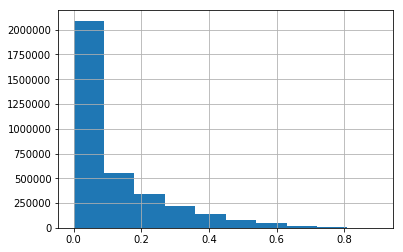

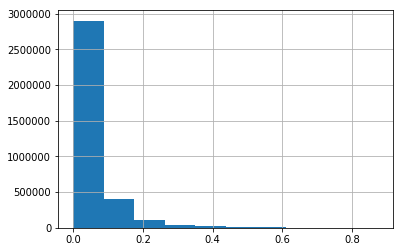

In [34]:
res_df.class_67.hist()
plt.show()
boost_df.class_67.hist()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb7a65bcc0>,
      dtype=object)

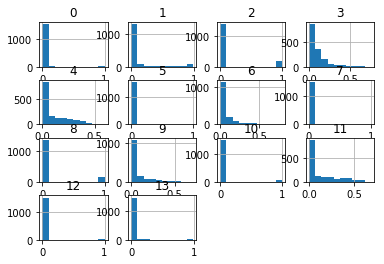

In [176]:
# val の段階ではいい感じに分布してる
pd.DataFrame(torch.nn.functional.softmax(best_val_res).detach().numpy()).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b7d04f080>,
      dtype=object)

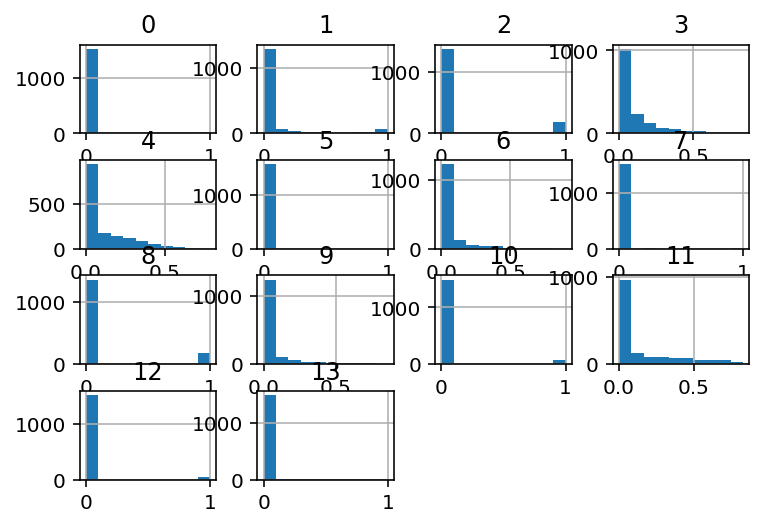

In [28]:
# val の段階ではいい感じに分布してる
pd.DataFrame(torch.nn.functional.softmax(best_val_res).detach().numpy()).hist()

Index(['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53',
       'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90',
       'class_92', 'class_95', 'class_99'],
      dtype='object')


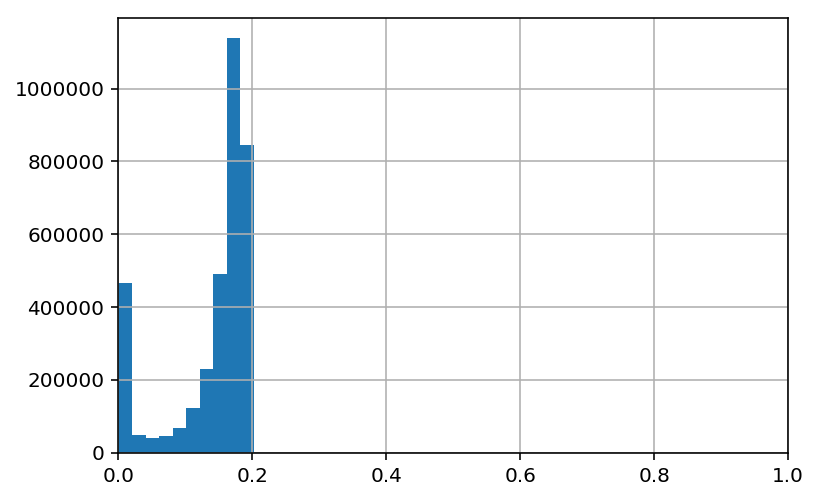

NameError: name 'boost_df' is not defined

In [29]:
class_num = 99
print(res_df.columns)
res_df[f'class_{class_num}'].hist()
plt.xlim((0, 1))
plt.show()
boost_df[f'class_{class_num}'].hist()
plt.xlim((0, 1))
plt.show()

In [32]:
boost_df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.579991_2018-11-18-12-47-32.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb7b1e01d0>,
      dtype=object)

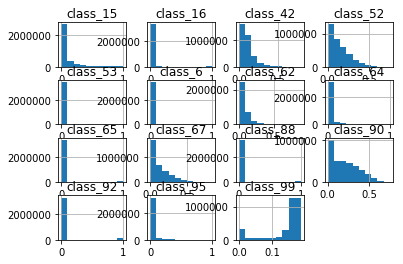

In [164]:
# val の段階ではいい感じに分布してる
pd.DataFrame(res_df).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7de00836d8>,
      dtype=object)

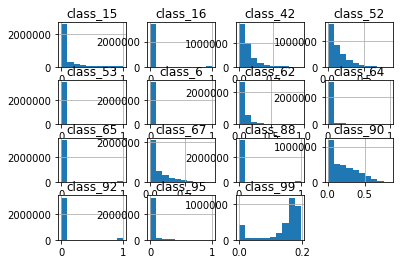

In [31]:
# val の段階ではいい感じに分布してる
pd.DataFrame(res_df).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0bedc8ba8>,
      dtype=object)

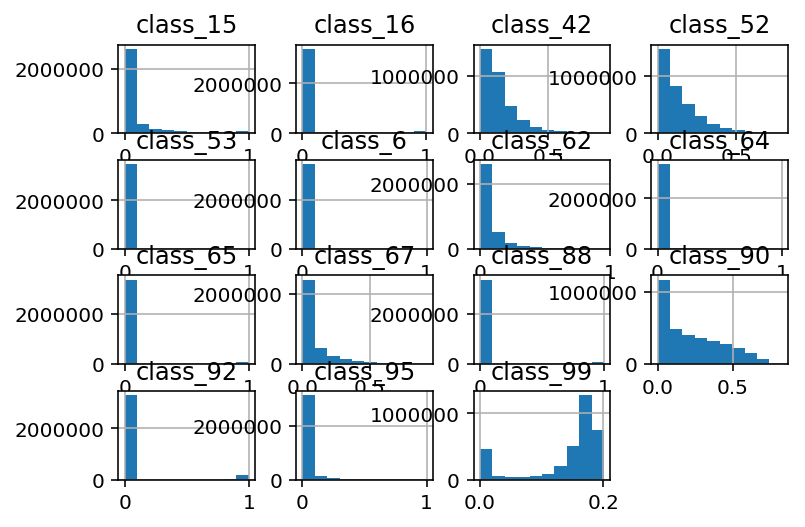

In [40]:
# val の段階ではいい感じに分布してる
pd.DataFrame(res_df).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7dc00b7e48>,
      dtype=object)

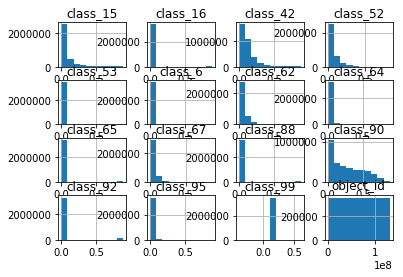

In [33]:
boost_df.hist()

In [1]:
import pandas as pd

In [32]:
meta_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/test_set_metadata.csv')
meta_df

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,13,34.453125,-5.229529,169.987075,-59.956185,1,0.3048,0.3193,0.0542,41.1123,0.019
1,14,33.398438,-4.331149,167.226341,-59.936551,1,NaN,0.6323,0.0179,42.8774,0.018
2,17,348.529419,-61.755440,321.293980,-51.763351,1,NaN,0.8297,0.0605,43.6000,0.016
3,23,34.804688,-5.829153,171.307861,-60.174401,1,NaN,0.6533,0.1479,42.9640,0.023
4,34,351.321442,-64.198746,317.458993,-50.429931,1,0.4557,0.4617,0.0122,42.0540,0.023
5,35,35.332031,-5.979157,172.286722,-59.931743,1,NaN,0.8388,0.0375,43.6290,0.022
6,43,0.574468,-45.981140,327.041068,-68.778764,1,NaN,0.6669,0.0546,43.0186,0.006
7,50,0.574468,-45.981140,327.041068,-68.778764,1,NaN,1.4663,0.0529,45.1281,0.006
8,60,346.562500,-63.448284,320.824720,-49.866957,1,NaN,0.9462,0.0116,43.9519,0.021
9,69,349.160583,-64.760857,318.219706,-49.458924,1,NaN,1.0432,0.1092,44.2138,0.020


In [30]:
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.577933_2018-11-29-20-26-36.csv')
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.566286_2018-12-02-11-58-49.csv')
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.565583_2018-12-02-17-18-53.csv')
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.564319_2018-12-03-21-33-50.csv')
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.561738_2018-12-04-16-29-27.csv')
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.536878_2018-12-05-22-41-21.csv')
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.550968_2018-12-06-22-05-46.csv')
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.499392_2018-12-08-15-34-26.csv')
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.551369_2018-12-09-13-05-52.csv')
#df = pd.read_csv('../submissions/PLASTICC_NET_weight-multi-logloss-0.603971.csv')
#df = pd.read_csv('../submissions/PLASTICC_NET_weight-multi-logloss-0.588983.csv')
df = pd.read_csv('../submissions/PLASTICC_NET_weight-multi-logloss-0.547902.csv')
df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,4.202068e-07,2.678525e-03,1.488424e-07,6.447581e-01,1.821782e-01,2.383359e-06,1.425613e-01,1.178347e-05,1.605805e-06,2.721957e-03,2.989185e-04,2.196986e-02,5.208498e-07,2.816352e-03,0.139848
1,14,1.610190e-05,2.739653e-01,1.793796e-05,2.064788e-01,1.184228e-01,3.944791e-07,1.239196e-02,9.208898e-05,3.157068e-04,3.149243e-03,2.598038e-04,3.725988e-01,5.484661e-06,1.228561e-02,0.179262
2,17,1.829358e-05,3.146071e-02,6.369509e-05,8.796285e-02,2.230423e-01,2.264835e-06,2.941398e-02,7.029009e-04,1.847229e-05,5.531190e-02,7.699103e-05,5.686482e-01,2.839133e-06,3.274569e-03,0.156495
3,23,2.123007e-05,7.967242e-03,3.390267e-06,4.951364e-02,1.075100e-01,7.045474e-06,5.777367e-02,1.269283e-04,2.365929e-06,3.821188e-01,5.292651e-06,3.920630e-01,8.360369e-07,2.886629e-03,0.171907
4,34,3.823335e-04,6.512191e-03,4.773437e-05,4.475295e-02,1.913857e-01,1.813217e-06,6.935473e-03,1.562282e-05,1.246554e-04,4.525085e-03,5.211591e-06,7.237642e-01,2.209267e-06,2.154492e-02,0.118638
5,35,9.862453e-04,3.377314e-03,2.816518e-04,5.227131e-02,1.398286e-01,7.236507e-05,2.080387e-02,3.385923e-04,2.667119e-04,1.358731e-01,7.059240e-05,5.846887e-01,1.963436e-05,6.112139e-02,0.154872
6,43,1.710494e-05,3.510132e-03,5.624276e-06,3.801701e-02,6.669817e-02,1.317231e-05,3.309808e-02,3.611913e-04,6.011398e-06,4.723148e-01,7.378195e-06,3.831367e-01,1.827291e-06,2.812759e-03,0.162493
7,50,1.608773e-04,2.386634e-02,2.001000e-04,1.011620e-01,1.021053e-01,1.063602e-04,5.236879e-02,3.388618e-02,3.803240e-04,1.844112e-01,2.673667e-04,4.761384e-01,1.553961e-04,2.479151e-02,0.173758
8,60,1.561380e-03,2.982988e-03,6.545773e-05,6.368520e-02,6.389453e-02,1.702785e-04,3.445508e-02,6.097294e-05,3.873109e-04,1.270179e-01,8.400562e-05,4.482365e-01,1.483810e-05,2.573836e-01,0.174323
9,69,1.402869e-04,7.279462e-03,6.592039e-06,5.835557e-02,7.603160e-02,2.736626e-05,7.274032e-02,2.100245e-04,1.625533e-05,3.987077e-01,1.175092e-05,3.709122e-01,1.387417e-06,1.555954e-02,0.172587


In [33]:
df.loc[df[meta_df.distmod.isnull()].index, ['class_15', 'class_42', 'class_52', 'class_62', 'class_64', 'class_67', 'class_88', 'class_90', 'class_95']] = 0.
df.loc[df[meta_df.distmod.notnull()].index, ['class_6', 'class_16', 'class_53', 'class_65', 'class_92']] = 0.
df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000000e+00,0.002679,0.000000,0.644758,0.182178,0.000000e+00,0.142561,0.000012,0.000000e+00,0.002722,0.000299,0.021970,0.000000,0.002816,0.139848
1,14,0.000000e+00,0.273965,0.000000,0.206479,0.118423,0.000000e+00,0.012392,0.000092,0.000000e+00,0.003149,0.000260,0.372599,0.000000,0.012286,0.179262
2,17,0.000000e+00,0.031461,0.000000,0.087963,0.223042,0.000000e+00,0.029414,0.000703,0.000000e+00,0.055312,0.000077,0.568648,0.000000,0.003275,0.156495
3,23,0.000000e+00,0.007967,0.000000,0.049514,0.107510,0.000000e+00,0.057774,0.000127,0.000000e+00,0.382119,0.000005,0.392063,0.000000,0.002887,0.171907
4,34,0.000000e+00,0.006512,0.000000,0.044753,0.191386,0.000000e+00,0.006935,0.000016,0.000000e+00,0.004525,0.000005,0.723764,0.000000,0.021545,0.118638
5,35,0.000000e+00,0.003377,0.000000,0.052271,0.139829,0.000000e+00,0.020804,0.000339,0.000000e+00,0.135873,0.000071,0.584689,0.000000,0.061121,0.154872
6,43,0.000000e+00,0.003510,0.000000,0.038017,0.066698,0.000000e+00,0.033098,0.000361,0.000000e+00,0.472315,0.000007,0.383137,0.000000,0.002813,0.162493
7,50,0.000000e+00,0.023866,0.000000,0.101162,0.102105,0.000000e+00,0.052369,0.033886,0.000000e+00,0.184411,0.000267,0.476138,0.000000,0.024792,0.173758
8,60,0.000000e+00,0.002983,0.000000,0.063685,0.063895,0.000000e+00,0.034455,0.000061,0.000000e+00,0.127018,0.000084,0.448236,0.000000,0.257384,0.174323
9,69,0.000000e+00,0.007279,0.000000,0.058356,0.076032,0.000000e+00,0.072740,0.000210,0.000000e+00,0.398708,0.000012,0.370912,0.000000,0.015560,0.172587


In [34]:
classes = ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']
#df[classes] / df[classes].sum(axis=1)
#df[classes].sum(axis=1)
#df[classes].sum(axis=1)
sum_row =  df[classes].sum(axis=1)
for _class in classes:
    df[_class] = df[_class] / sum_row
df[classes].sum(axis=1)

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
5          1.0
6          1.0
7          1.0
8          1.0
9          1.0
10         1.0
11         1.0
12         1.0
13         1.0
14         1.0
15         1.0
16         1.0
17         1.0
18         1.0
19         1.0
20         1.0
21         1.0
22         1.0
23         1.0
24         1.0
25         1.0
26         1.0
27         1.0
28         1.0
29         1.0
          ... 
3492860    1.0
3492861    1.0
3492862    1.0
3492863    1.0
3492864    1.0
3492865    1.0
3492866    1.0
3492867    1.0
3492868    1.0
3492869    1.0
3492870    1.0
3492871    1.0
3492872    1.0
3492873    1.0
3492874    1.0
3492875    1.0
3492876    1.0
3492877    1.0
3492878    1.0
3492879    1.0
3492880    1.0
3492881    1.0
3492882    1.0
3492883    1.0
3492884    1.0
3492885    1.0
3492886    1.0
3492887    1.0
3492888    1.0
3492889    1.0
Length: 3492890, dtype: float64

In [35]:
import numpy as np

res = df[classes].values

preds_99 = np.ones((res.shape[0]))
for i in range(res.shape[1]):
    preds_99 *= (1 - res[:, i])
    
preds_99 = 0.14 * preds_99 / np.mean(preds_99)
preds_99

array([0.14017897, 0.1796625 , 0.15685274, ..., 0.16495955, 0.08388851,
       0.16833085])

In [36]:
df['class_99'] = preds_99
df['class_99']

0          0.140179
1          0.179663
2          0.156853
3          0.172312
4          0.118791
5          0.155019
6          0.162874
7          0.174083
8          0.174551
9          0.172980
10         0.123345
11         0.047184
12         0.119052
13         0.174054
14         0.071806
15         0.172936
16         0.142733
17         0.181972
18         0.173924
19         0.175485
20         0.000005
21         0.104336
22         0.183704
23         0.163424
24         0.169707
25         0.166379
26         0.180195
27         0.153387
28         0.170826
29         0.151674
             ...   
3492860    0.159029
3492861    0.182417
3492862    0.179039
3492863    0.161348
3492864    0.007277
3492865    0.194359
3492866    0.175081
3492867    0.156701
3492868    0.000018
3492869    0.178194
3492870    0.098191
3492871    0.184431
3492872    0.007517
3492873    0.183315
3492874    0.165887
3492875    0.189231
3492876    0.167919
3492877    0.181404
3492878    0.161000


In [40]:
new_classes = ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95', 'class_99']
#df[classes] / df[classes].sum(axis=1)
#df[classes].sum(axis=1)
#df[classes].sum(axis=1)
sum_row =  df[new_classes].sum(axis=1)
for _class in new_classes:
    df[_class] = df[_class] / sum_row
df[new_classes].sum(axis=1)

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
5          1.0
6          1.0
7          1.0
8          1.0
9          1.0
10         1.0
11         1.0
12         1.0
13         1.0
14         1.0
15         1.0
16         1.0
17         1.0
18         1.0
19         1.0
20         1.0
21         1.0
22         1.0
23         1.0
24         1.0
25         1.0
26         1.0
27         1.0
28         1.0
29         1.0
          ... 
3492860    1.0
3492861    1.0
3492862    1.0
3492863    1.0
3492864    1.0
3492865    1.0
3492866    1.0
3492867    1.0
3492868    1.0
3492869    1.0
3492870    1.0
3492871    1.0
3492872    1.0
3492873    1.0
3492874    1.0
3492875    1.0
3492876    1.0
3492877    1.0
3492878    1.0
3492879    1.0
3492880    1.0
3492881    1.0
3492882    1.0
3492883    1.0
3492884    1.0
3492885    1.0
3492886    1.0
3492887    1.0
3492888    1.0
3492889    1.0
Length: 3492890, dtype: float64

In [41]:
df.set_index('object_id').head().sum(axis=1)

object_id
13    1.0
14    1.0
17    1.0
23    1.0
34    1.0
dtype: float64

In [42]:
#df.to_csv('../submissions/Booster_weight-multi-logloss-0.577933_2018-11-29-20-26-36_setzero.csv.gz', compression='gzip', index=False)
#df.to_csv('../submissions/Booster_weight-multi-logloss-0.577933_2018-11-29-20-26-36_setzero.csv', index=False)

#df.to_csv('../submissions/Booster_weight-multi-logloss-0.566286_2018-12-02-11-58-49_setzero.csv.gz', compression='gzip', index=False)
#df.to_csv('../submissions/Booster_weight-multi-logloss-0.564319_2018-12-03-21-33-50_setzero.csv.gz', compression='gzip', index=False)
#df.to_csv('../submissions/Booster_weight-multi-logloss-0.561738_2018-12-04-16-29-27_setzero.csv.gz', compression='gzip', index=False)
#df.to_csv('../submissions/Booster_weight-multi-logloss-0.536878_2018-12-05-22-41-21_setzero.csv.gz', compression='gzip', index=False)
#df.to_csv('../submissions/Booster_weight-multi-logloss-0.550968_2018-12-06-22-05-46_setzero.csv.gz', compression='gzip', index=False)
#df.to_csv('../submissions/Booster_weight-multi-logloss-0.499392_2018-12-08-15-34-26_setzero.csv.gz', compression='gzip', index=False)
#df.to_csv('../submissions/Booster_weight-multi-logloss-0.551369_2018-12-09-13-05-52_setzero.csv.gz', compression='gzip', index=False)
#df.to_csv('../submissions/PLASTICC_NET_weight-multi-logloss-0.603971_setzero.csv.gz', compression='gzip', index=False)
#df.to_csv('../submissions/PLASTICC_NET_weight-multi-logloss-0.588983_setzero.csv.gz', compression='gzip', index=False)
df.to_csv('../submissions/PLASTICC_NET_weight-multi-logloss-0.547902_setzero.csv.gz', compression='gzip', index=False)

In [9]:
base_df = pd.read_csv('../submissions/missions/Booster_weight-multi-logloss-0.564319_2018-12-03-21-33-50_setzero.csv.gz', compression='gzip')

In [10]:
base_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000000,0.002913,0.000000,0.802358,0.125578,0.000000,0.026871,0.002182,0.000000,0.005433,0.002550,0.027496,0.000000,0.004619,0.092847
1,14,0.000000,0.169164,0.000000,0.299889,0.061850,0.000000,0.092716,0.008943,0.000000,0.033649,0.008663,0.301890,0.000000,0.023236,0.185214
2,17,0.000000,0.074995,0.000000,0.116977,0.041368,0.000000,0.054915,0.032107,0.000000,0.051364,0.019354,0.518858,0.000000,0.090063,0.168566
3,23,0.000000,0.003465,0.000000,0.078313,0.016799,0.000000,0.059094,0.004455,0.000000,0.427543,0.004458,0.354922,0.000000,0.050951,0.170544
4,34,0.000000,0.004299,0.000000,0.027294,0.061495,0.000000,0.014927,0.002367,0.000000,0.014695,0.002703,0.868748,0.000000,0.003471,0.066341
5,35,0.000000,0.005546,0.000000,0.059429,0.017867,0.000000,0.029847,0.006056,0.000000,0.033036,0.004220,0.669907,0.000000,0.174094,0.134368
6,43,0.000000,0.006252,0.000000,0.062990,0.035608,0.000000,0.083156,0.011897,0.000000,0.173975,0.006662,0.540456,0.000000,0.079004,0.163250
7,50,0.000000,0.053438,0.000000,0.041887,0.025447,0.000000,0.084217,0.331109,0.000000,0.136191,0.011398,0.153333,0.000000,0.162981,0.189327
8,60,0.000000,0.004106,0.000000,0.055276,0.008631,0.000000,0.072625,0.004839,0.000000,0.212337,0.003359,0.493321,0.000000,0.145506,0.169056
9,69,0.000000,0.009997,0.000000,0.087665,0.027421,0.000000,0.098862,0.006874,0.000000,0.207924,0.005682,0.168830,0.000000,0.386745,0.182365


In [14]:
base_df.loc[base_df[meta_df.hostgal_specz.notnull()].index, classes + ['class_99']] = df.loc[base_df[meta_df.hostgal_specz.notnull()].index, classes + ['class_99']]

In [15]:
base_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000000,0.009872,0.000000,0.671662,0.179785,0.000000,0.056465,0.007193,0.000000,0.012714,0.007024,0.047861,0.000000,0.007424,0.105624
1,14,0.000000,0.169164,0.000000,0.299889,0.061850,0.000000,0.092716,0.008943,0.000000,0.033649,0.008663,0.301890,0.000000,0.023236,0.185214
2,17,0.000000,0.074995,0.000000,0.116977,0.041368,0.000000,0.054915,0.032107,0.000000,0.051364,0.019354,0.518858,0.000000,0.090063,0.168566
3,23,0.000000,0.003465,0.000000,0.078313,0.016799,0.000000,0.059094,0.004455,0.000000,0.427543,0.004458,0.354922,0.000000,0.050951,0.170544
4,34,0.000000,0.003702,0.000000,0.031564,0.021804,0.000000,0.006340,0.002510,0.000000,0.004691,0.002579,0.922842,0.000000,0.003968,0.032574
5,35,0.000000,0.005546,0.000000,0.059429,0.017867,0.000000,0.029847,0.006056,0.000000,0.033036,0.004220,0.669907,0.000000,0.174094,0.134368
6,43,0.000000,0.006252,0.000000,0.062990,0.035608,0.000000,0.083156,0.011897,0.000000,0.173975,0.006662,0.540456,0.000000,0.079004,0.163250
7,50,0.000000,0.053438,0.000000,0.041887,0.025447,0.000000,0.084217,0.331109,0.000000,0.136191,0.011398,0.153333,0.000000,0.162981,0.189327
8,60,0.000000,0.004106,0.000000,0.055276,0.008631,0.000000,0.072625,0.004839,0.000000,0.212337,0.003359,0.493321,0.000000,0.145506,0.169056
9,69,0.000000,0.009997,0.000000,0.087665,0.027421,0.000000,0.098862,0.006874,0.000000,0.207924,0.005682,0.168830,0.000000,0.386745,0.182365


In [16]:
base_df.to_csv('../submissions/Booster_0.564319_2018-12-03-21-33-50_w_0.499392_2018-12-08-15-34-26.csv.gz', compression='gzip', index=False)

#### アンサンブル

In [53]:
import pandas as pd

In [54]:
classes = ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']

In [55]:
df1 = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.551369_2018-12-09-13-05-52_setzero.csv.gz', compression='gzip')
#df2= pd.read_csv('../submissions/PLASTICC_NET_weight-multi-logloss-0.603971_setzero.csv.gz', compression='gzip')
df2= pd.read_csv('../submissions/PLASTICC_NET_weight-multi-logloss-0.588983_setzero.csv.gz', compression='gzip')

In [56]:
df1

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000000,0.004269,0.000000,0.789091,0.131593,0.000000,0.022329,0.002932,0.000000,0.006450,0.003369,0.034441,0.000000,0.005525,0.097963
1,14,0.000000,0.184192,0.000000,0.231951,0.044154,0.000000,0.141412,0.009446,0.000000,0.032229,0.009557,0.314015,0.000000,0.033044,0.187690
2,17,0.000000,0.087890,0.000000,0.111097,0.030105,0.000000,0.047918,0.041440,0.000000,0.064161,0.018462,0.512012,0.000000,0.086915,0.170231
3,23,0.000000,0.004049,0.000000,0.095346,0.018738,0.000000,0.088870,0.004329,0.000000,0.310874,0.005149,0.414158,0.000000,0.058487,0.175774
4,34,0.000000,0.004392,0.000000,0.026470,0.059490,0.000000,0.015490,0.002728,0.000000,0.012172,0.002730,0.872967,0.000000,0.003561,0.064683
5,35,0.000000,0.005626,0.000000,0.065826,0.019423,0.000000,0.029544,0.004839,0.000000,0.033595,0.004352,0.681280,0.000000,0.155514,0.132034
6,43,0.000000,0.005054,0.000000,0.090836,0.020814,0.000000,0.078768,0.014595,0.000000,0.231513,0.005902,0.481114,0.000000,0.071405,0.171532
7,50,0.000000,0.036523,0.000000,0.042103,0.037158,0.000000,0.060170,0.381645,0.000000,0.162546,0.009953,0.141858,0.000000,0.128044,0.185679
8,60,0.000000,0.004081,0.000000,0.061869,0.011710,0.000000,0.062693,0.003439,0.000000,0.191680,0.003392,0.514164,0.000000,0.146971,0.166881
9,69,0.000000,0.008534,0.000000,0.087763,0.035391,0.000000,0.092506,0.009665,0.000000,0.233606,0.006089,0.163803,0.000000,0.362643,0.184478


In [57]:
ensambled_df = df1.copy()
ensambled_df.loc[:, classes + ['class_99']] = (ensambled_df.loc[:, classes + ['class_99']] + df2.loc[:, classes + ['class_99']])/2

In [58]:
ensambled_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000000,0.004986,0.000000,0.717234,0.156534,0.000000,0.072909,0.001479,0.000000,0.004468,0.001875,0.034867,0.000000,0.005648,0.118789
1,14,0.000000,0.302436,0.000000,0.184370,0.052255,0.000000,0.075229,0.004758,0.000000,0.017988,0.004967,0.334845,0.000000,0.023151,0.178908
2,17,0.000000,0.050993,0.000000,0.109899,0.107744,0.000000,0.038285,0.020768,0.000000,0.058143,0.009287,0.546663,0.000000,0.058219,0.162371
3,23,0.000000,0.005278,0.000000,0.098355,0.093608,0.000000,0.099977,0.002210,0.000000,0.298177,0.002578,0.367013,0.000000,0.032805,0.179752
4,34,0.000000,0.006602,0.000000,0.038534,0.114959,0.000000,0.010922,0.001374,0.000000,0.012598,0.001415,0.799172,0.000000,0.014424,0.091466
5,35,0.000000,0.005055,0.000000,0.060689,0.067654,0.000000,0.026748,0.002554,0.000000,0.086792,0.002246,0.611435,0.000000,0.136827,0.147373
6,43,0.000000,0.005907,0.000000,0.072691,0.065662,0.000000,0.054890,0.007377,0.000000,0.211324,0.002971,0.533358,0.000000,0.045819,0.162447
7,50,0.000000,0.032009,0.000000,0.067438,0.057140,0.000000,0.050834,0.194831,0.000000,0.150093,0.005795,0.324369,0.000000,0.117491,0.177536
8,60,0.000000,0.004595,0.000000,0.060938,0.036910,0.000000,0.047834,0.001763,0.000000,0.142592,0.001809,0.458107,0.000000,0.245451,0.170445
9,69,0.000000,0.012681,0.000000,0.086167,0.058409,0.000000,0.091787,0.004917,0.000000,0.252501,0.003057,0.282456,0.000000,0.208026,0.181780


In [59]:
ensambled_df[ensambled_df > 1.].any()

object_id     True
class_6      False
class_15     False
class_16     False
class_42     False
class_52     False
class_53     False
class_62     False
class_64     False
class_65     False
class_67     False
class_88     False
class_90     False
class_92     False
class_95     False
class_99     False
dtype: bool

In [61]:
ensambled_df.to_csv('../submissions/PLASTICC_NET_0.588983_Booster_0.551369_setzero.csv.gz', compression='gzip', index=False)

In [142]:
ensambled_df.to_csv('../submissions/PLASTICC_NET_0.603971_Booster_0.551369_setzero.csv', index=False)

In [145]:
pd.read_csv('../submissions/PLASTICC_NET_0.603971_Booster_0.551369_setzero.csv')

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000000,0.008024,0.000000,0.407350,0.392325,0.000000,0.136753,0.000397,0.000000,0.029480,0.000546,0.147130,0.000000,0.002994,0.132269
1,14,0.000000,0.247324,0.000000,0.179825,0.126623,0.000000,0.040603,0.001418,0.000000,0.021314,0.002302,0.461697,0.000000,0.043895,0.177094
2,17,0.000000,0.028218,0.000000,0.107438,0.216957,0.000000,0.050784,0.005569,0.000000,0.122172,0.002448,0.569301,0.000000,0.022113,0.163518
3,23,0.000000,0.011630,0.000000,0.093107,0.137490,0.000000,0.150787,0.000912,0.000000,0.413889,0.000658,0.303519,0.000000,0.013009,0.172852
4,34,0.000000,0.011281,0.000000,0.050485,0.206121,0.000000,0.023428,0.000418,0.000000,0.081998,0.000403,0.736770,0.000000,0.014096,0.099824
5,35,0.000000,0.008818,0.000000,0.090872,0.154936,0.000000,0.038746,0.001175,0.000000,0.114090,0.000820,0.621551,0.000000,0.093991,0.142793
6,43,0.000000,0.007277,0.000000,0.079757,0.162049,0.000000,0.083347,0.002401,0.000000,0.338494,0.000774,0.434421,0.000000,0.016479,0.169269
7,50,0.000000,0.036620,0.000000,0.086976,0.091330,0.000000,0.072461,0.111791,0.000000,0.316361,0.001593,0.365628,0.000000,0.042240,0.178682
8,60,0.000000,0.007379,0.000000,0.099766,0.082293,0.000000,0.071682,0.000779,0.000000,0.101603,0.000914,0.320460,0.000000,0.440123,0.166606
9,69,0.000000,0.008892,0.000000,0.100765,0.115862,0.000000,0.124327,0.002092,0.000000,0.338264,0.000831,0.340998,0.000000,0.092968,0.178232


In [12]:
import pickle
with open('../oof/Booster_weight-multi-logloss-0.561738_2018-12-04-09-54-47.pkl', 'rb') as fin:
    oof = pickle.load(fin)

In [25]:
def softmax(x, axis=1):
    z = np.exp(x)
    return z/np.sum(z, axis=axis, keepdims=True)

oof_df = pd.DataFrame(np.concatenate([softmax(_oof[0]) for _oof in oof]), columns=classes)
oof_df

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,0.005961,0.009482,0.005816,0.487105,0.095486,0.006973,0.100653,0.007371,0.005801,0.028073,0.008519,0.033697,0.006582,0.198480
1,0.001067,0.002287,0.001045,0.004371,0.105787,0.001122,0.004989,0.001000,0.001131,0.003281,0.001207,0.869722,0.001157,0.001834
2,0.001171,0.001736,0.001152,0.009880,0.037552,0.001235,0.006321,0.001074,0.001238,0.002316,0.001181,0.932689,0.001275,0.001180
3,0.000603,0.000772,0.000682,0.001452,0.001376,0.000415,0.001933,0.000359,0.988646,0.000950,0.000432,0.000975,0.000469,0.000936
4,0.001609,0.003099,0.001581,0.020251,0.078220,0.001838,0.016993,0.001581,0.001788,0.030176,0.001829,0.836210,0.001771,0.003056
5,0.000953,0.002068,0.000936,0.012375,0.021882,0.001074,0.004156,0.000870,0.001051,0.002301,0.001042,0.949013,0.001029,0.001251
6,0.000148,0.000478,0.000109,0.000861,0.000231,0.003380,0.000385,0.000186,0.000131,0.000121,0.874491,0.000209,0.118157,0.001112
7,0.002456,0.000613,0.979787,0.001048,0.001162,0.000384,0.000785,0.000381,0.010351,0.000859,0.000620,0.000653,0.000423,0.000477
8,0.003306,0.161695,0.003001,0.161010,0.191054,0.003783,0.036095,0.282924,0.003502,0.017391,0.004325,0.118433,0.003541,0.009941
9,0.000355,0.000362,0.000334,0.000621,0.000531,0.000215,0.001016,0.000619,0.994253,0.000468,0.000228,0.000522,0.000237,0.000241


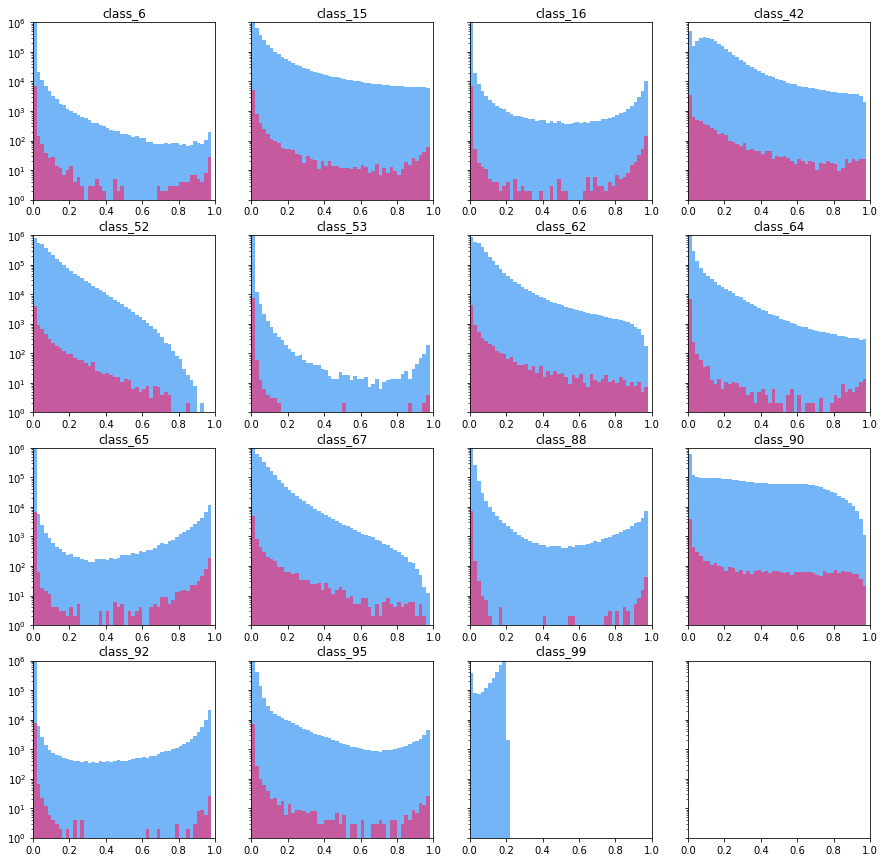

In [29]:
from matplotlib import pyplot as plt

f, axs = plt.subplots(4, 4, figsize=(15, 15), sharey=True)

for i, _class in enumerate(classes + ['class_99']):
    ax = axs[i // 4, i % 4]
    ax.hist(df[_class], color='#73B5F7', bins=np.arange(0., 1., 0.02))
    if _class in oof_df.columns:
        ax.hist(oof_df[_class], color='#C65A9E', bins=np.arange(0., 1., 0.02))
    ax.set_xlim((0., 1.))
    ax.set_ylim((1, 1000000))
    ax.set_title(_class)
    plt.yscale('log')

plt.show()

In [34]:
np.where(~np.isnan(meta_df.values[:, np.where(meta_df.columns == 'distmod')[0]]))[0].shape

(3102380,)

In [39]:
print(meta_df.values[:, np.where(meta_df.columns == 'distmod')[0]])

[[41.1123]
 [42.8774]
 [43.6   ]
 ...
 [38.7604]
 [41.8625]
 [41.4333]]


In [29]:
gal_cols = []
'class_15', 'class_42', 'class_52', 'class_62', 'class_64', 'class_67', 'class_88', 'class_90', 'class_95'
df.drop('object_id', axis=1)

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,0.000000,0.003854,0.000000,0.757541,0.148584,0.000000,0.027996,0.001862,0.000000,0.006058,0.002385,0.046821,0.000000,0.004901,0.108304
1,0.000000,0.069573,0.000000,0.293300,0.084550,0.000000,0.092506,0.014400,0.000000,0.026068,0.010698,0.373161,0.000000,0.035744,0.180976
2,0.000000,0.029193,0.000000,0.126021,0.048475,0.000000,0.053682,0.084634,0.000000,0.031645,0.021408,0.506177,0.000000,0.098765,0.170236
3,0.000000,0.004055,0.000000,0.120193,0.017667,0.000000,0.064569,0.010884,0.000000,0.415792,0.005952,0.299580,0.000000,0.061309,0.175515
4,0.000000,0.005734,0.000000,0.027542,0.047367,0.000000,0.012139,0.001964,0.000000,0.008405,0.002680,0.890486,0.000000,0.003684,0.056558
5,0.000000,0.005381,0.000000,0.073593,0.023259,0.000000,0.025978,0.006465,0.000000,0.034004,0.005162,0.591879,0.000000,0.234278,0.150972
6,0.000000,0.004186,0.000000,0.051679,0.031432,0.000000,0.068683,0.023900,0.000000,0.178667,0.005478,0.573851,0.000000,0.062124,0.156680
7,0.000000,0.036206,0.000000,0.037124,0.019911,0.000000,0.065038,0.316597,0.000000,0.154842,0.007858,0.173800,0.000000,0.188624,0.188551
8,0.000000,0.003900,0.000000,0.067581,0.008756,0.000000,0.049847,0.005006,0.000000,0.254408,0.003637,0.386577,0.000000,0.220287,0.178501
9,0.000000,0.006540,0.000000,0.078011,0.029227,0.000000,0.086441,0.006723,0.000000,0.142666,0.005550,0.288671,0.000000,0.356170,0.181842


In [46]:
df.values[[0, 1, 2], :]

array([[1.30000000e+01, 0.00000000e+00, 3.85351982e-03, 0.00000000e+00,
        7.57540919e-01, 1.48583832e-01, 0.00000000e+00, 2.79957963e-02,
        1.86213454e-03, 0.00000000e+00, 6.05772668e-03, 2.38473090e-03,
        4.68205216e-02, 0.00000000e+00, 4.90081839e-03, 1.08304377e-01],
       [1.40000000e+01, 0.00000000e+00, 6.95730121e-02, 0.00000000e+00,
        2.93300170e-01, 8.45500860e-02, 0.00000000e+00, 9.25055702e-02,
        1.44003224e-02, 0.00000000e+00, 2.60678997e-02, 1.06978355e-02,
        3.73160987e-01, 0.00000000e+00, 3.57441170e-02, 1.80975935e-01],
       [1.70000000e+01, 0.00000000e+00, 2.91926789e-02, 0.00000000e+00,
        1.26021084e-01, 4.84752546e-02, 0.00000000e+00, 5.36819119e-02,
        8.46342600e-02, 0.00000000e+00, 3.16452497e-02, 2.14079697e-02,
        5.06176574e-01, 0.00000000e+00, 9.87650178e-02, 1.70235548e-01]])

In [5]:
df = pd.read_feather('../test_dfs/test_df_for_nn.fth')
df

,object_id,hostgal_photoz_err,distmod,lumi_dist,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_var,...,internal,c90_z_z1,c90_y_z1,c52_y_z1,c67_g_z2,c67_i_z2,c67_y_z2,c52_r_z3,c42_i_z4,c42_z_z4
0,13,0.0542,41.1123,1.669014e+09,-12.680235,42.765503,3.997127,0.616561,9.149645,8.371600e+01,...,False,9.390269,1.943906,2.993463,1.898032,11.232923,2.344784,6.132683,6.578410,9.933218
1,14,0.0179,42.8774,3.762530e+09,-11.142164,14.839427,0.884047,0.072856,3.399946,1.155963e+01,...,False,NaN,NaN,NaN,0.972816,1.197749,NaN,1.107778,1.070769,NaN
2,17,0.0605,43.6000,5.248075e+09,-14.202744,16.761280,0.791032,0.458391,3.886578,1.510549e+01,...,False,NaN,NaN,NaN,1.361492,1.101139,NaN,1.270988,1.311761,NaN
3,23,0.1479,42.9640,3.915615e+09,-12.631923,28.061138,0.970396,0.465986,4.100713,1.681584e+01,...,False,0.737174,NaN,NaN,NaN,1.653800,NaN,1.146899,1.613232,0.852435
4,34,0.0122,42.0540,2.575135e+09,-13.239577,124.475609,4.580070,0.301366,19.862714,3.945274e+02,...,False,5.367685,2.063274,1.488509,7.534384,20.952691,1.476331,61.873673,17.218760,6.591742
5,35,0.0375,43.6290,5.318633e+09,-9.032743,34.847000,1.800237,0.589795,5.726820,3.279646e+01,...,False,1.500328,0.734977,1.075497,NaN,3.164535,0.975357,1.811993,3.462126,1.307392
6,43,0.0546,43.0186,4.015319e+09,-10.711065,23.771006,0.533671,0.096750,3.428601,1.175530e+01,...,False,NaN,NaN,NaN,NaN,1.508438,NaN,0.930497,1.293318,NaN
7,50,0.0529,45.1281,1.060767e+10,-21.568415,12.179604,0.012805,0.009715,3.409948,1.162774e+01,...,False,NaN,NaN,NaN,NaN,NaN,NaN,1.419350,NaN,NaN
8,60,0.0116,43.9519,6.171347e+09,-21.433050,28.675814,1.480276,0.087896,6.017310,3.620802e+01,...,False,1.260674,NaN,NaN,NaN,1.514927,NaN,1.231022,1.784987,1.186469
9,69,0.1092,44.2138,6.962417e+09,-14.229353,35.446308,1.388202,0.398017,5.941994,3.530729e+01,...,False,1.873220,1.030602,0.985040,NaN,1.318693,0.960344,1.300163,1.912828,1.838702


In [7]:
train_cols = ['hostgal_photoz_err', 'distmod', 'lumi_dist', 'index', 'flux_min', 'flux_max', 'flux_mean', 'flux_median', 'flux_std', 'flux_var', 'flux_skew', 'flux_count', 'flux_kurtosis', 'corrected_flux_min', 'corrected_flux_max', 'corrected_flux_mean', 'corrected_flux_median', 'corrected_flux_std', 'corrected_flux_var', 'corrected_flux_skew', 'flux_err_min', 'flux_err_max', 'flux_err_mean', 'flux_err_median', 'flux_err_std', 'flux_err_var', 'flux_err_skew', 'flux_err_kurtosis', 'flux_ratio_to_flux_err_min', 'flux_ratio_to_flux_err_max', 'detected_mean', 'flux_ratio_sq_skew', 'flux_ratio_sq_mean', 'flux_ratio_sq_kurtosis', 'flux_by_flux_ratio_sq_sum', 'flux_by_flux_ratio_sq_skew', 'corrected_flux_ratio_sq_sum', 'corrected_flux_ratio_sq_skew', 'corrected_flux_by_flux_ratio_sq_sum', 'corrected_flux_by_flux_ratio_sq_skew', 'std_upper_mjd_get_max_min_diff', 'std_upper_mjd_var', 'std_upper_mjd_skew', 'std_upper_flux_count', 'std_upper_flux_min', 'detected_mjd_get_max_min_diff', 'detected_mjd_skew', 'band-0_wmean', 'band-0_normed_std', 'band-0_normed_amp', 'band-0_normed_mad', 'band-0_beyond_1std', 'band-0_flux_var', 'band-0_flux_skew', 'band-0_flux_kurtosis', 'band-0_flux_quantile10', 'band-0_flux_quantile25', 'band-0_flux_quantile75', 'band-0_flux_quantile90', 'band-0_flux_quantile2575_range', 'band-0_flux_quantile1090_range', 'band-0_normed_flux_diff_mean', 'band-0_detected_mean', 'band-0_flux_ratio_sq_sum', 'band-0_flux_ratio_sq_skew', 'band-0_flux_by_flux_ratio_sq_sum', 'band-0_flux_by_flux_ratio_sq_skew', 'band-0_flux_diff', 'band-0_std_upper_mjd_get_max_min_diff', 'band-0_std_upper_mjd_var', 'band-0_std_upper_mjd_skew', 'band-0_std_upper_mjd_diff_mean', 'band-0_std_upper_flux_count', 'band-0_std_upper_flux_diff_mean', 'band-1_wmean', 'band-1_normed_std', 'band-1_normed_amp', 'band-1_normed_mad', 'band-1_beyond_1std', 'band-1_flux_var', 'band-1_flux_skew', 'band-1_flux_kurtosis', 'band-1_flux_quantile10', 'band-1_flux_quantile25', 'band-1_flux_quantile75', 'band-1_flux_quantile90', 'band-1_flux_quantile2575_range', 'band-1_flux_quantile1090_range', 'band-1_normed_flux_diff_mean', 'band-1_detected_mean', 'band-1_flux_ratio_sq_sum', 'band-1_flux_ratio_sq_skew', 'band-1_flux_by_flux_ratio_sq_sum', 'band-1_flux_by_flux_ratio_sq_skew', 'band-1_flux_diff', 'band-1_std_upper_mjd_get_max_min_diff', 'band-1_std_upper_mjd_var', 'band-1_std_upper_mjd_skew', 'band-1_std_upper_mjd_diff_mean', 'band-1_std_upper_flux_count', 'band-1_std_upper_flux_diff_mean', 'band-2_wmean', 'band-2_normed_std', 'band-2_normed_amp', 'band-2_normed_mad', 'band-2_beyond_1std', 'band-2_flux_var', 'band-2_flux_skew', 'band-2_flux_kurtosis', 'band-2_flux_quantile10', 'band-2_flux_quantile25', 'band-2_flux_quantile75', 'band-2_flux_quantile90', 'band-2_flux_quantile2575_range', 'band-2_flux_quantile1090_range', 'band-2_normed_flux_diff_mean', 'band-2_detected_mean', 'band-2_flux_ratio_sq_sum', 'band-2_flux_ratio_sq_skew', 'band-2_flux_by_flux_ratio_sq_sum', 'band-2_flux_by_flux_ratio_sq_skew', 'band-2_flux_diff', 'band-2_std_upper_mjd_get_max_min_diff', 'band-2_std_upper_mjd_var', 'band-2_std_upper_mjd_skew', 'band-2_std_upper_mjd_diff_mean', 'band-2_std_upper_flux_count', 'band-2_std_upper_flux_diff_mean', 'band-3_wmean', 'band-3_normed_std', 'band-3_normed_amp', 'band-3_normed_mad', 'band-3_beyond_1std', 'band-3_flux_var', 'band-3_flux_skew', 'band-3_flux_kurtosis', 'band-3_flux_quantile10', 'band-3_flux_quantile25', 'band-3_flux_quantile75', 'band-3_flux_quantile90', 'band-3_flux_quantile2575_range', 'band-3_flux_quantile1090_range', 'band-3_normed_flux_diff_mean', 'band-3_detected_mean', 'band-3_flux_ratio_sq_sum', 'band-3_flux_ratio_sq_skew', 'band-3_flux_by_flux_ratio_sq_sum', 'band-3_flux_by_flux_ratio_sq_skew', 'band-3_flux_diff', 'band-3_std_upper_mjd_get_max_min_diff', 'band-3_std_upper_mjd_var','band-3_std_upper_mjd_skew', 'band-3_std_upper_mjd_diff_mean', 'band-3_std_upper_flux_count', 'band-3_std_upper_flux_diff_mean', 'band-4_wmean', 'band-4_normed_std', 'band-4_normed_amp', 'band-4_normed_mad', 'band-4_beyond_1std', 'band-4_flux_var', 'band-4_flux_skew', 'band-4_flux_kurtosis', 'band-4_flux_quantile10', 'band-4_flux_quantile25', 'band-4_flux_quantile75', 'band-4_flux_quantile90', 'band-4_flux_quantile2575_range', 'band-4_flux_quantile1090_range', 'band-4_normed_flux_diff_mean', 'band-4_detected_mean', 'band-4_flux_ratio_sq_sum', 'band-4_flux_ratio_sq_skew', 'band-4_flux_by_flux_ratio_sq_sum', 'band-4_flux_by_flux_ratio_sq_skew', 'band-4_flux_diff', 'band-4_std_upper_mjd_get_max_min_diff','band-4_std_upper_mjd_var', 'band-4_std_upper_mjd_skew', 'band-4_std_upper_mjd_diff_mean', 'band-4_std_upper_flux_count', 'band-4_std_upper_flux_diff_mean', 'band-5_wmean', 'band-5_normed_std', 'band-5_normed_amp', 'band-5_normed_mad', 'band-5_beyond_1std', 'band-5_flux_var', 'band-5_flux_skew', 'band-5_flux_kurtosis', 'band-5_flux_quantile10', 'band-5_flux_quantile25', 'band-5_flux_quantile75', 'band-5_flux_quantile90', 'band-5_flux_quantile2575_range', 'band-5_flux_quantile1090_range', 'band-5_normed_flux_diff_mean', 'band-5_detected_mean', 'band-5_flux_ratio_sq_sum', 'band-5_flux_ratio_sq_skew', 'band-5_flux_by_flux_ratio_sq_sum', 'band-5_flux_by_flux_ratio_sq_skew', 'band-5_flux_diff', 'band-5_std_upper_mjd_get_max_min_diff', 'band-5_std_upper_mjd_var', 'band-5_std_upper_mjd_skew', 'band-5_std_upper_mjd_diff_mean', 'band-5_std_upper_flux_count', 'band-5_std_upper_flux_diff_mean', '0_minus_1_wmean', '0_minus_1_std', '0_minus_1_amp', '1_minus_2_wmean', '1_minus_2_std', '1_minus_2_amp', '2_minus_3_wmean', '2_minus_3_std', '2_minus_3_amp', '3_minus_4_wmean', '3_minus_4_std', '3_minus_4_amp', '4_minus_5_wmean', '4_minus_5_std', '4_minus_5_amp', '5_minus_0_wmean', '5_minus_0_std', '5_minus_0_amp', 'flux_diff', 'flux_dif2', 'flux_w_mean', 'flux_dif3', 'corrected_flux_diff', 'corrected_flux_dif2', 'corrected_flux_w_mean', 'corrected_flux_dif3', 'std_upper_rat', 'band-0_flux_max_ratio_to_the_max', 'band-1_flux_max_ratio_to_the_max', 'band-2_flux_max_ratio_to_the_max', 'band-3_flux_max_ratio_to_the_max', 'band-4_flux_max_ratio_to_the_max', 'band-5_flux_max_ratio_to_the_max', 'passband_flux_min_var', 'passband_flux_means_var', 'passband_flux_counts_var', 'passband_detected_means_var', 'band_flux_diff_max', 'band_flux_diff_min', 'band_flux_diff_diff', 'band_flux_diff_diff_rat', 'band_flux_max_min_rat', '0__length', '0__longest_strike_above_mean', '0__longest_strike_below_mean', '0__mean_abs_change', '0__mean_change', '1__length', '1__longest_strike_above_mean', '1__longest_strike_below_mean', '1__mean_abs_change', '1__mean_change', '2__length', '2__longest_strike_above_mean', '2__longest_strike_below_mean', '2__mean_abs_change', '2__mean_change', '3__length', '3__longest_strike_above_mean', '3__longest_strike_below_mean', '3__mean_abs_change', '3__mean_change', '4__length', '4__longest_strike_above_mean', '4__longest_strike_below_mean', '4__mean_abs_change', '4__mean_change', '5__length', '5__longest_strike_above_mean', '5__longest_strike_below_mean', '5__mean_abs_change', '5__mean_change', 'internal', 'c90_z_z1', 'c90_y_z1', 'c52_y_z1', 'c67_g_z2', 'c67_i_z2', 'c67_y_z2', 'c52_r_z3', 'c42_i_z4', 'c42_z_z4']
for tr, te in zip(train_cols, df.columns.tolist()):
    print(tr, te)

hostgal_photoz_err object_id
distmod hostgal_photoz_err
lumi_dist distmod
index lumi_dist
flux_min flux_min
flux_max flux_max
flux_mean flux_mean
flux_median flux_median
flux_std flux_std
flux_var flux_var
flux_skew flux_skew
flux_count flux_count
flux_kurtosis flux_kurtosis
corrected_flux_min corrected_flux_min
corrected_flux_max corrected_flux_max
corrected_flux_mean corrected_flux_mean
corrected_flux_median corrected_flux_median
corrected_flux_std corrected_flux_std
corrected_flux_var corrected_flux_var
corrected_flux_skew corrected_flux_skew
flux_err_min flux_err_min
flux_err_max flux_err_max
flux_err_mean flux_err_mean
flux_err_median flux_err_median
flux_err_std flux_err_std
flux_err_var flux_err_var
flux_err_skew flux_err_skew
flux_err_kurtosis flux_err_kurtosis
flux_ratio_to_flux_err_min flux_ratio_to_flux_err_min
flux_ratio_to_flux_err_max flux_ratio_to_flux_err_max
detected_mean detected_mean
flux_ratio_sq_skew flux_ratio_sq_skew
flux_ratio_sq_mean flux_ratio_sq_mean
flux_rat

In [94]:
set(df.columns.tolist()) - set(train_cols)

{'level_0'}

In [2]:
import pickle
#with open('../lcfit/LCfit_features_train_20181129.pkl', 'rb') as fin:
with open('../lcfit/LCfit_feature_test_v1_20181203.pkl', 'rb') as fin:
    lc_df = pickle.load(fin)
lc_df    

,object_id,c90_z_z1,c90_y_z1,c52_y_z1,c67_g_z2,c67_i_z2,c67_y_z2,c52_r_z3,c42_i_z4,c42_z_z4
0,13,9.390269,1.943906,2.993463,1.898032,11.232923,2.344784,6.132683,6.578410,9.933218
1,14,NaN,NaN,NaN,0.972816,1.197749,NaN,1.107778,1.070769,NaN
2,17,NaN,NaN,NaN,1.361492,1.101139,NaN,1.270988,1.311761,NaN
3,23,0.737174,NaN,NaN,NaN,1.653800,NaN,1.146899,1.613232,0.852435
4,34,5.367685,2.063274,1.488509,7.534384,20.952691,1.476331,61.873673,17.218760,6.591742
5,35,1.500328,0.734977,1.075497,NaN,3.164535,0.975357,1.811993,3.462126,1.307392
6,43,NaN,NaN,NaN,NaN,1.508438,NaN,0.930497,1.293318,NaN
7,50,NaN,NaN,NaN,NaN,NaN,NaN,1.419350,NaN,NaN
8,60,1.260674,NaN,NaN,NaN,1.514927,NaN,1.231022,1.784987,1.186469
9,69,1.873220,1.030602,0.985040,NaN,1.318693,0.960344,1.300163,1.912828,1.838702


In [112]:
trn_meta_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set_metadata.csv')
trn_meta_df

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0000,0.0000,0.0000,NaN,0.020,65
6,1598,347.846710,-64.760857,318.929827,-49.143596,1,0.1352,0.1820,0.0304,39.7279,0.019,90
7,1632,348.595886,-63.072620,320.023289,-50.713060,1,0.6857,0.7014,0.0100,43.1524,0.021,42
8,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027,90
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0000,0.0000,0.0000,NaN,0.018,65


In [15]:
df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set.csv')
res = df[['object_id', 'flux']].groupby('object_id').std()
res

,flux
object_id,
615,394.109851
713,6.471144
730,8.022239
745,27.558208
1124,20.051722
1227,4.962633
1598,167.317942
1632,5.273147
1920,48.004394


In [116]:
set(meta_df.object_id.tolist()) - set(lc_df.object_id.tolist()) 

{104853812}

In [10]:
lc_df[lc_df.object_id.isin([316251, 1171843, 104853812])]
#meta_df

,object_id,c90_z_z1,c90_y_z1,c52_y_z1,c67_g_z2,c67_i_z2,c67_y_z2,c52_r_z3,c42_i_z4,c42_z_z4
30321,316251,4.650208,2.927517,3.667827,2.381219,10.800067,3.734305,9.807716,7.234254,5.668269
729552,1171843,NaN,0.945728,0.979031,NaN,8.790004,0.950105,1.248422,4.627052,NaN
729554,1171843,NaN,NaN,NaN,NaN,15.549649,NaN,0.906817,14.418170,NaN


In [8]:
df[df.object_id == 1171843]

,object_id,hostgal_photoz_err,distmod,lumi_dist,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_var,...,internal,c90_z_z1,c90_y_z1,c52_y_z1,c67_g_z2,c67_i_z2,c67_y_z2,c52_r_z3,c42_i_z4,c42_z_z4
37560,1171843,0.9714,39.9601,9.817932e+08,-43.239304,87.945724,12.587251,6.528358,24.75865,612.990756,...,False,NaN,0.945728,0.979031,NaN,8.790004,0.950105,1.248422,4.627052,NaN
37561,1171843,0.9714,39.9601,9.817932e+08,-43.239304,87.945724,12.587251,6.528358,24.75865,612.990756,...,False,NaN,NaN,NaN,NaN,15.549649,NaN,0.906817,14.418170,NaN


In [5]:
pd.read_feather('../features/train/set_std_upper_and_lower_features.ftr').columns.tolist()

['object_id',
 'std_upper_mjd_get_max_min_diff',
 'std_upper_mjd_var',
 'std_upper_mjd_skew',
 'std_upper_flux_count',
 'std_upper_flux_min',
 'std_lower_mjd_get_max_min_diff',
 'std_lower_mjd_var',
 'std_lower_mjd_skew',
 'std_lower_flux_count',
 'std_lower_flux_max']

In [40]:
!ls ../features/train/

set_base_features.ftr	   set_passband_std_upper_features.ftr
set_detected_features.ftr  set_std_upper_and_lower_features.ftr
set_passband_features.ftr  set_tsfresh_features.ftr


In [2]:
import pandas as pd

In [3]:
test_dfs = []
for i in range(62):
    test_dfs.append(pd.read_feather(f'../test_dfs/{i}.fth'))

In [4]:
set_meta_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/test_set_metadata.csv')

In [19]:
import numpy as np
import gc

def _add_corrected_flux(set_df, set_metadata_df):
    set_metadata_df['lumi_dist'] = 10**((set_metadata_df.distmod+5)/5)
    _set_metadata_df = set_metadata_df
    set_df = set_df.merge(
        _set_metadata_df[['object_id', 'hostgal_photoz', 'lumi_dist', 'distmod', 'hostgal_specz']],
        on='object_id',
        how='left')
    set_df['corrected_flux'] = set_df.flux / (set_df.hostgal_photoz**2)
    set_df['z_corrected_flux'] = set_df.flux / (set_df.hostgal_specz**2)
    set_df['normed_flux'] = (set_df.flux - set_df.flux.min()) / set_df.flux.max()
    set_df['luminosity'] = 4*np.pi*(set_df.lumi_dist**2)*set_df.flux
    # set_df['z_luminosity'] = 4*np.pi*(set_df.z_lumi_dist**2)*set_df.flux
    set_df['magnitude'] = -2.5*np.log10(set_df.flux)
    set_df['abs_magnitude'] = set_df.magnitude - set_df.distmod
    del set_df['magnitude'], set_df['distmod'], set_df['hostgal_specz'], set_df['lumi_dist']
    gc.collect()
    return set_df

In [20]:
from tqdm import tqdm_notebook as tqdm

added_test_dfs = []

for set_df in tqdm(test_dfs):
    added_test_df = _add_corrected_flux(set_df, set_meta_df)
    added_test_dfs.append(added_test_df)

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


In [28]:
classes = ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']
oof_dfs = [pd.DataFrame(_oof[0], index=_oof[2], columns=classes) for _oof in oof]

In [32]:
oof_res_df = pd.concat(oof_dfs, axis=0).reset_index().rename(columns={'index': 'object_id'})
oof_res_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,12,-2.507093,1.285585,-4.033751,5.112932,2.333887,-5.100410,2.999557,-2.809572,-3.501791,-1.593581,3.514150,2.189129,-5.208544,7.046820
1,29,-2.197612,1.878258,-1.144167,4.391348,5.933817,-7.591757,1.745734,-3.420627,-1.773633,2.395791,-2.921358,7.325164,-7.487088,3.023682
2,31,-5.237882,2.596065,-2.964122,5.912808,8.244333,-7.731372,3.820307,-2.361668,-5.204138,4.601481,-2.930803,7.857442,-7.168402,0.758983
3,32,3.072891,-1.168564,1.004347,-1.987295,-4.514895,-0.185050,-4.719636,-0.251256,15.305566,-4.340131,0.628909,-1.165719,1.260031,0.099772
4,34,-1.859045,2.133647,-3.802820,4.128616,5.866593,-5.654284,3.507569,-2.235985,-3.445148,6.020599,-5.336419,6.667546,-6.515434,0.320545
5,36,-3.504375,2.406477,-1.781901,4.981819,6.979972,-7.777256,2.565219,-3.053829,-3.391128,3.377039,-3.019027,7.720250,-7.359931,1.911885
6,37,-6.375005,-0.466548,-0.105180,5.311351,0.578022,-2.623766,2.165219,-1.912202,-4.903932,-7.252113,13.119958,-3.230172,5.773910,0.736016
7,42,1.373261,-2.929796,13.214943,-2.793361,-1.444646,-1.453521,-5.493981,-2.421328,1.421408,-4.062311,3.206117,-0.269513,2.342108,-0.432118
8,43,-4.508501,6.258815,-5.785669,5.920253,5.787460,-8.025375,4.164179,-1.126800,-5.578765,3.204895,-1.810927,5.982255,-5.634662,0.197078
9,48,2.720577,-1.777346,1.291222,-2.455295,-4.936124,0.795521,-4.876564,1.468848,15.708981,-4.049744,0.006037,-1.587075,1.094566,-0.711963


In [34]:
import pickle
with open('../oof/Booster_weight-multi-logloss-0.551369_2018-12-09-13-05-52.pkl', 'rb') as fin:
    lgb_oof = pickle.load(fin)

In [35]:
classes = ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']
lgb_oof_dfs = [pd.DataFrame(_oof[0], index=_oof[2], columns=classes) for _oof in lgb_oof]
lgb_oof_res_df = pd.concat(lgb_oof_dfs, axis=0).reset_index().rename(columns={'index': 'object_id'})
lgb_oof_res_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,12,-1.290339,-0.896002,-1.310426,3.232355,1.127125,-1.136353,1.236271,-1.397379,-1.279289,-0.275230,-0.883141,0.225574,-1.197876,2.422455
1,29,-1.296348,-0.668461,-1.321830,-0.048092,3.183029,-1.222526,-0.157935,-1.369885,-1.239807,-0.463596,-1.049976,5.131292,-1.219752,-1.130753
2,31,-1.296348,-0.928421,-1.325155,1.157180,2.404485,-1.230078,-0.205020,-1.377369,-1.246875,-0.533131,-1.279372,5.146091,-1.219752,-1.327859
3,32,-1.049857,-0.639454,-0.581247,0.167168,-0.165598,-1.154434,0.180160,-1.303557,6.903914,-0.157596,-1.090737,-0.446027,-1.028852,-0.942083
4,34,-1.288866,-0.929665,-1.309138,1.067470,2.952994,-1.177991,0.767845,-0.975553,-1.196288,1.376498,-1.201954,4.636478,-1.197115,-0.744751
5,36,-1.285627,-0.678404,-1.309138,1.363391,1.876014,-1.171576,-0.159347,-1.400924,-1.196288,-0.317707,-1.236238,5.781991,-1.197876,-1.004935
6,37,-0.968992,0.077086,-1.490322,0.758486,-0.466461,1.651510,0.093527,-1.372075,-1.274272,-1.384478,6.742714,-0.954214,5.012461,1.093899
7,42,0.372631,-0.596543,6.632709,-0.322455,-0.204894,-1.137788,-0.596919,-1.118476,2.063782,-0.280895,-0.707324,-0.699655,-1.005787,-0.937769
8,43,-1.347640,2.739828,-1.417277,2.566439,1.617126,-1.213462,1.014204,1.940882,-1.350617,0.096309,-1.124418,2.074242,-1.315889,-0.498052
9,48,-0.729798,-0.951294,-0.614709,-0.248617,-0.282875,-1.140126,0.189983,-0.380219,7.285773,-0.419891,-1.102776,-0.293213,-1.035146,-1.017965


In [37]:
oof_res_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,12,-2.507093,1.285585,-4.033751,5.112932,2.333887,-5.100410,2.999557,-2.809572,-3.501791,-1.593581,3.514150,2.189129,-5.208544,7.046820
1,29,-2.197612,1.878258,-1.144167,4.391348,5.933817,-7.591757,1.745734,-3.420627,-1.773633,2.395791,-2.921358,7.325164,-7.487088,3.023682
2,31,-5.237882,2.596065,-2.964122,5.912808,8.244333,-7.731372,3.820307,-2.361668,-5.204138,4.601481,-2.930803,7.857442,-7.168402,0.758983
3,32,3.072891,-1.168564,1.004347,-1.987295,-4.514895,-0.185050,-4.719636,-0.251256,15.305566,-4.340131,0.628909,-1.165719,1.260031,0.099772
4,34,-1.859045,2.133647,-3.802820,4.128616,5.866593,-5.654284,3.507569,-2.235985,-3.445148,6.020599,-5.336419,6.667546,-6.515434,0.320545
5,36,-3.504375,2.406477,-1.781901,4.981819,6.979972,-7.777256,2.565219,-3.053829,-3.391128,3.377039,-3.019027,7.720250,-7.359931,1.911885
6,37,-6.375005,-0.466548,-0.105180,5.311351,0.578022,-2.623766,2.165219,-1.912202,-4.903932,-7.252113,13.119958,-3.230172,5.773910,0.736016
7,42,1.373261,-2.929796,13.214943,-2.793361,-1.444646,-1.453521,-5.493981,-2.421328,1.421408,-4.062311,3.206117,-0.269513,2.342108,-0.432118
8,43,-4.508501,6.258815,-5.785669,5.920253,5.787460,-8.025375,4.164179,-1.126800,-5.578765,3.204895,-1.810927,5.982255,-5.634662,0.197078
9,48,2.720577,-1.777346,1.291222,-2.455295,-4.936124,0.795521,-4.876564,1.468848,15.708981,-4.049744,0.006037,-1.587075,1.094566,-0.711963


In [36]:
lgb_oof_res_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,12,-1.290339,-0.896002,-1.310426,3.232355,1.127125,-1.136353,1.236271,-1.397379,-1.279289,-0.275230,-0.883141,0.225574,-1.197876,2.422455
1,29,-1.296348,-0.668461,-1.321830,-0.048092,3.183029,-1.222526,-0.157935,-1.369885,-1.239807,-0.463596,-1.049976,5.131292,-1.219752,-1.130753
2,31,-1.296348,-0.928421,-1.325155,1.157180,2.404485,-1.230078,-0.205020,-1.377369,-1.246875,-0.533131,-1.279372,5.146091,-1.219752,-1.327859
3,32,-1.049857,-0.639454,-0.581247,0.167168,-0.165598,-1.154434,0.180160,-1.303557,6.903914,-0.157596,-1.090737,-0.446027,-1.028852,-0.942083
4,34,-1.288866,-0.929665,-1.309138,1.067470,2.952994,-1.177991,0.767845,-0.975553,-1.196288,1.376498,-1.201954,4.636478,-1.197115,-0.744751
5,36,-1.285627,-0.678404,-1.309138,1.363391,1.876014,-1.171576,-0.159347,-1.400924,-1.196288,-0.317707,-1.236238,5.781991,-1.197876,-1.004935
6,37,-0.968992,0.077086,-1.490322,0.758486,-0.466461,1.651510,0.093527,-1.372075,-1.274272,-1.384478,6.742714,-0.954214,5.012461,1.093899
7,42,0.372631,-0.596543,6.632709,-0.322455,-0.204894,-1.137788,-0.596919,-1.118476,2.063782,-0.280895,-0.707324,-0.699655,-1.005787,-0.937769
8,43,-1.347640,2.739828,-1.417277,2.566439,1.617126,-1.213462,1.014204,1.940882,-1.350617,0.096309,-1.124418,2.074242,-1.315889,-0.498052
9,48,-0.729798,-0.951294,-0.614709,-0.248617,-0.282875,-1.140126,0.189983,-0.380219,7.285773,-0.419891,-1.102776,-0.293213,-1.035146,-1.017965


In [38]:
def softmax(x, axis=1):
    z = np.exp(x)
    return z/np.sum(z, axis=axis, keepdims=True)

In [39]:
lgb_oof_res_df.loc[lgb_oof_res_df.index, classes] = softmax(lgb_oof_res_df.loc[lgb_oof_res_df.index, classes].values)
lgb_oof_res_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,12,0.005773,0.008563,0.005658,0.531560,0.064753,0.006734,0.072221,0.005187,0.005837,0.015930,0.008674,0.026286,0.006332,0.236493
1,29,0.001377,0.002580,0.001342,0.004798,0.121418,0.001482,0.004299,0.001279,0.001457,0.003166,0.001762,0.851928,0.001487,0.001625
2,31,0.001439,0.002080,0.001399,0.016740,0.058272,0.001538,0.004287,0.001327,0.001512,0.003088,0.001464,0.903904,0.001554,0.001395
3,32,0.000349,0.000525,0.000557,0.001177,0.000844,0.000314,0.001193,0.000270,0.992203,0.000851,0.000335,0.000638,0.000356,0.000388
4,34,0.002051,0.002937,0.002010,0.021641,0.142613,0.002291,0.016038,0.002806,0.002250,0.029478,0.002237,0.767866,0.002248,0.003534
5,36,0.000815,0.001496,0.000796,0.011522,0.019238,0.000913,0.002513,0.000726,0.000891,0.002145,0.000856,0.956120,0.000890,0.001079
6,37,0.000375,0.001066,0.000222,0.002108,0.000619,0.005148,0.001084,0.000250,0.000276,0.000247,0.836939,0.000380,0.148339,0.002947
7,42,0.001874,0.000711,0.980486,0.000935,0.001052,0.000414,0.000711,0.000422,0.010167,0.000975,0.000636,0.000641,0.000472,0.000505
8,43,0.004761,0.283683,0.004440,0.238523,0.092310,0.005444,0.050513,0.127601,0.004747,0.020173,0.005951,0.145805,0.004914,0.011134
9,48,0.000329,0.000263,0.000369,0.000532,0.000514,0.000218,0.000824,0.000466,0.994815,0.000448,0.000226,0.000508,0.000242,0.000246


In [40]:
oof_res_df.loc[oof_res_df.index, classes] = softmax(oof_res_df.loc[oof_res_df.index, classes].values)
oof_res_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,12,5.854029e-05,2.597732e-03,1.271850e-05,1.193411e-01,7.410812e-03,4.377154e-06,1.441992e-02,4.326034e-05,2.165025e-05,1.459447e-04,2.412390e-02,6.412073e-03,3.928527e-06,8.254041e-01
1,29,5.496058e-05,3.237272e-03,1.576001e-04,3.995766e-02,1.868469e-01,2.496914e-07,2.835467e-03,1.617717e-05,8.398135e-05,5.431760e-03,2.665215e-05,7.511737e-01,2.772432e-07,1.017724e-02
2,31,7.673746e-07,1.937524e-03,7.455702e-06,5.341836e-02,5.498686e-01,6.340129e-08,6.590655e-03,1.361856e-05,7.937106e-07,1.439423e-02,7.708307e-06,3.734514e-01,1.113251e-07,3.086119e-04
3,32,4.868706e-06,7.004436e-08,6.152563e-07,3.088892e-08,2.466493e-09,1.872871e-07,2.009843e-09,1.752891e-07,9.999924e-01,2.937507e-09,4.226743e-07,7.024387e-08,7.945084e-07,2.490029e-07
4,34,9.404154e-05,5.097110e-03,1.346322e-05,3.747380e-02,2.130698e-01,2.113821e-06,2.013773e-02,6.450849e-05,1.925236e-05,2.485453e-01,2.904794e-06,4.746475e-01,8.934613e-07,8.315790e-04
5,36,8.506005e-06,3.138891e-03,4.761969e-05,4.123184e-02,3.041024e-01,1.185870e-07,3.678889e-03,1.334736e-05,9.525952e-06,8.284871e-03,1.382005e-05,6.375558e-01,1.800026e-07,1.914156e-03
6,37,3.411744e-09,1.255991e-06,1.802713e-06,4.057852e-04,3.569748e-06,1.452508e-07,1.745615e-05,2.959013e-07,1.485440e-08,1.419231e-09,9.989210e-01,7.920631e-08,6.444409e-04,4.180742e-06
7,42,7.197587e-06,9.736284e-08,9.999176e-01,1.115954e-07,4.299181e-07,4.261192e-07,7.495177e-09,1.618893e-07,7.552608e-06,3.137243e-08,4.499731e-05,1.392321e-06,1.896497e-05,1.183372e-06
8,43,6.447749e-06,3.059103e-01,1.797799e-06,2.180511e-01,1.909358e-01,1.914472e-07,3.766215e-02,1.896977e-04,2.211049e-06,1.443090e-02,9.570833e-05,2.319987e-01,2.090848e-06,7.128781e-04
9,48,2.286684e-06,2.545556e-08,5.475770e-07,1.292270e-08,1.081292e-09,3.335529e-07,1.147651e-09,6.540137e-07,9.999955e-01,2.623572e-09,1.514594e-07,3.079047e-08,4.498196e-07,7.387079e-08


In [41]:
meta_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set_metadata.csv')

In [43]:
oof_res_df.loc[oof_res_df[meta_df.distmod.isnull()].index, ['class_15', 'class_42', 'class_52', 'class_62', 'class_64', 'class_67', 'class_88', 'class_90', 'class_95']] = 0.
oof_res_df.loc[oof_res_df[meta_df.distmod.notnull()].index, ['class_6', 'class_16', 'class_53', 'class_65', 'class_92']] = 0.
oof_res_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,12,5.854029e-05,0.000000e+00,1.271850e-05,0.000000e+00,0.000000e+00,4.377154e-06,0.000000e+00,0.000000e+00,2.165025e-05,0.000000e+00,0.000000e+00,0.000000e+00,3.928527e-06,0.000000e+00
1,29,0.000000e+00,3.237272e-03,0.000000e+00,3.995766e-02,1.868469e-01,0.000000e+00,2.835467e-03,1.617717e-05,0.000000e+00,5.431760e-03,2.665215e-05,7.511737e-01,0.000000e+00,1.017724e-02
2,31,0.000000e+00,1.937524e-03,0.000000e+00,5.341836e-02,5.498686e-01,0.000000e+00,6.590655e-03,1.361856e-05,0.000000e+00,1.439423e-02,7.708307e-06,3.734514e-01,0.000000e+00,3.086119e-04
3,32,0.000000e+00,7.004436e-08,0.000000e+00,3.088892e-08,2.466493e-09,0.000000e+00,2.009843e-09,1.752891e-07,0.000000e+00,2.937507e-09,4.226743e-07,7.024387e-08,0.000000e+00,2.490029e-07
4,34,0.000000e+00,5.097110e-03,0.000000e+00,3.747380e-02,2.130698e-01,0.000000e+00,2.013773e-02,6.450849e-05,0.000000e+00,2.485453e-01,2.904794e-06,4.746475e-01,0.000000e+00,8.315790e-04
5,36,8.506005e-06,0.000000e+00,4.761969e-05,0.000000e+00,0.000000e+00,1.185870e-07,0.000000e+00,0.000000e+00,9.525952e-06,0.000000e+00,0.000000e+00,0.000000e+00,1.800026e-07,0.000000e+00
6,37,0.000000e+00,1.255991e-06,0.000000e+00,4.057852e-04,3.569748e-06,0.000000e+00,1.745615e-05,2.959013e-07,0.000000e+00,1.419231e-09,9.989210e-01,7.920631e-08,0.000000e+00,4.180742e-06
7,42,0.000000e+00,9.736284e-08,0.000000e+00,1.115954e-07,4.299181e-07,0.000000e+00,7.495177e-09,1.618893e-07,0.000000e+00,3.137243e-08,4.499731e-05,1.392321e-06,0.000000e+00,1.183372e-06
8,43,0.000000e+00,3.059103e-01,0.000000e+00,2.180511e-01,1.909358e-01,0.000000e+00,3.766215e-02,1.896977e-04,0.000000e+00,1.443090e-02,9.570833e-05,2.319987e-01,0.000000e+00,7.128781e-04
9,48,2.286684e-06,0.000000e+00,5.475770e-07,0.000000e+00,0.000000e+00,3.335529e-07,0.000000e+00,0.000000e+00,9.999955e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.498196e-07,0.000000e+00


In [44]:
lgb_oof_res_df.loc[lgb_oof_res_df[meta_df.distmod.isnull()].index, ['class_15', 'class_42', 'class_52', 'class_62', 'class_64', 'class_67', 'class_88', 'class_90', 'class_95']] = 0.
lgb_oof_res_df.loc[lgb_oof_res_df[meta_df.distmod.notnull()].index, ['class_6', 'class_16', 'class_53', 'class_65', 'class_92']] = 0.
lgb_oof_res_df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,12,0.005773,0.000000,0.005658,0.000000,0.000000,0.006734,0.000000,0.000000,0.005837,0.000000,0.000000,0.000000,0.006332,0.000000
1,29,0.000000,0.002580,0.000000,0.004798,0.121418,0.000000,0.004299,0.001279,0.000000,0.003166,0.001762,0.851928,0.000000,0.001625
2,31,0.000000,0.002080,0.000000,0.016740,0.058272,0.000000,0.004287,0.001327,0.000000,0.003088,0.001464,0.903904,0.000000,0.001395
3,32,0.000000,0.000525,0.000000,0.001177,0.000844,0.000000,0.001193,0.000270,0.000000,0.000851,0.000335,0.000638,0.000000,0.000388
4,34,0.000000,0.002937,0.000000,0.021641,0.142613,0.000000,0.016038,0.002806,0.000000,0.029478,0.002237,0.767866,0.000000,0.003534
5,36,0.000815,0.000000,0.000796,0.000000,0.000000,0.000913,0.000000,0.000000,0.000891,0.000000,0.000000,0.000000,0.000890,0.000000
6,37,0.000000,0.001066,0.000000,0.002108,0.000619,0.000000,0.001084,0.000250,0.000000,0.000247,0.836939,0.000380,0.000000,0.002947
7,42,0.000000,0.000711,0.000000,0.000935,0.001052,0.000000,0.000711,0.000422,0.000000,0.000975,0.000636,0.000641,0.000000,0.000505
8,43,0.000000,0.283683,0.000000,0.238523,0.092310,0.000000,0.050513,0.127601,0.000000,0.020173,0.005951,0.145805,0.000000,0.011134
9,48,0.000329,0.000000,0.000369,0.000000,0.000000,0.000218,0.000000,0.000000,0.994815,0.000000,0.000000,0.000000,0.000242,0.000000


In [45]:
res_df = (oof_res_df.set_index('object_id') + lgb_oof_res_df.set_index('object_id'))/2
res_df

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
object_id,,,,,,,,,,,,,,
12,0.002916,0.000000,0.002835,0.000000,0.000000,0.003369,0.000000,0.000000,0.002929,0.000000,0.000000,0.000000,0.003168,0.000000
29,0.000000,0.002909,0.000000,0.022378,0.154133,0.000000,0.003567,0.000648,0.000000,0.004299,0.000894,0.801551,0.000000,0.005901
31,0.000000,0.002009,0.000000,0.035079,0.304070,0.000000,0.005439,0.000671,0.000000,0.008741,0.000736,0.638678,0.000000,0.000852
32,0.000000,0.000263,0.000000,0.000589,0.000422,0.000000,0.000596,0.000135,0.000000,0.000425,0.000168,0.000319,0.000000,0.000194
34,0.000000,0.004017,0.000000,0.029558,0.177841,0.000000,0.018088,0.001435,0.000000,0.139012,0.001120,0.621257,0.000000,0.002183
36,0.000412,0.000000,0.000422,0.000000,0.000000,0.000457,0.000000,0.000000,0.000450,0.000000,0.000000,0.000000,0.000445,0.000000
37,0.000000,0.000534,0.000000,0.001257,0.000311,0.000000,0.000551,0.000125,0.000000,0.000124,0.917930,0.000190,0.000000,0.001476
42,0.000000,0.000356,0.000000,0.000468,0.000526,0.000000,0.000355,0.000211,0.000000,0.000487,0.000341,0.000321,0.000000,0.000253
43,0.000000,0.294797,0.000000,0.228287,0.141623,0.000000,0.044088,0.063896,0.000000,0.017302,0.003024,0.188902,0.000000,0.005923


In [49]:
sum_row =  res_df[classes].sum(axis=1)

for _class in classes:
    res_df[_class] = res_df[_class] / sum_row
res_df[classes].sum(axis=1)

object_id
12      1.0
29      1.0
31      1.0
32      1.0
34      1.0
36      1.0
37      1.0
42      1.0
43      1.0
48      1.0
52      1.0
55      1.0
68      1.0
73      1.0
83      1.0
89      1.0
90      1.0
92      1.0
104     1.0
105     1.0
115     1.0
127     1.0
136     1.0
139     1.0
140     1.0
160     1.0
165     1.0
175     1.0
176     1.0
178     1.0
       ... 
7708    1.0
7712    1.0
7717    1.0
7719    1.0
7733    1.0
7736    1.0
7738    1.0
7739    1.0
7754    1.0
7755    1.0
7758    1.0
7759    1.0
7760    1.0
7779    1.0
7781    1.0
7790    1.0
7791    1.0
7798    1.0
7805    1.0
7807    1.0
7813    1.0
7826    1.0
7829    1.0
7830    1.0
7833    1.0
7840    1.0
7843    1.0
7845    1.0
7846    1.0
7847    1.0
Length: 7848, dtype: float64

In [50]:
res_df.to_pickle('/home/naoya.taguchi/taguchi_oof_nn_and_lgbm_0.940.pkl.gz', compression='gzip')

In [18]:
import pandas as pd

In [19]:
df = pd.read_csv('../submissions/PLASTICC_NET_weight-multi-logloss-0.547902_setzero.csv.gz', compression='gzip')

In [33]:
df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000000e+00,0.002349,0.000000,0.565491,0.159781,0.000000e+00,0.125035,0.000010,0.000000e+00,0.002387,0.000262,0.019269,0.000000,0.002470,0.122945
1,14,0.000000e+00,0.232323,0.000000,0.175094,0.100423,0.000000e+00,0.010508,0.000078,0.000000e+00,0.002671,0.000220,0.315964,0.000000,0.010418,0.152300
2,17,0.000000e+00,0.027198,0.000000,0.076044,0.192821,0.000000e+00,0.025429,0.000608,0.000000e+00,0.047817,0.000067,0.491600,0.000000,0.002831,0.135586
3,23,0.000000e+00,0.006796,0.000000,0.042237,0.091711,0.000000e+00,0.049284,0.000108,0.000000e+00,0.325964,0.000005,0.334447,0.000000,0.002462,0.146985
4,34,0.000000e+00,0.005824,0.000000,0.040024,0.171160,0.000000e+00,0.006203,0.000014,0.000000e+00,0.004047,0.000005,0.647278,0.000000,0.019268,0.106178
5,35,0.000000e+00,0.002929,0.000000,0.045330,0.121259,0.000000e+00,0.018041,0.000294,0.000000e+00,0.117829,0.000061,0.507041,0.000000,0.053004,0.134213
6,43,0.000000e+00,0.003019,0.000000,0.032694,0.057359,0.000000e+00,0.028464,0.000311,0.000000e+00,0.406179,0.000006,0.329488,0.000000,0.002419,0.140062
7,50,0.000000e+00,0.020348,0.000000,0.086249,0.087053,0.000000e+00,0.044649,0.028891,0.000000e+00,0.157226,0.000228,0.405948,0.000000,0.021137,0.148271
8,60,0.000000e+00,0.002545,0.000000,0.054340,0.054519,0.000000e+00,0.029399,0.000052,0.000000e+00,0.108380,0.000072,0.382465,0.000000,0.219617,0.148611
9,69,0.000000e+00,0.006207,0.000000,0.049759,0.064832,0.000000e+00,0.062025,0.000179,0.000000e+00,0.339975,0.000010,0.316274,0.000000,0.013268,0.147470


In [28]:
df.set_index('object_id').sum(axis=1).astype(int).unique()

array([1, 0])

In [29]:
series = df.set_index('object_id').sum(axis=1)
df[series==0]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [2]:
import pandas as pd
df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set_metadata.csv')
df

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0000,0.0000,0.0000,NaN,0.020,65
6,1598,347.846710,-64.760857,318.929827,-49.143596,1,0.1352,0.1820,0.0304,39.7279,0.019,90
7,1632,348.595886,-63.072620,320.023289,-50.713060,1,0.6857,0.7014,0.0100,43.1524,0.021,42
8,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027,90
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0000,0.0000,0.0000,NaN,0.018,65


In [3]:
df[['ra', 'object_id', 'hostgal_specz']]

,ra,object_id,hostgal_specz
0,349.046051,615,0.0000
1,53.085938,713,1.8181
2,33.574219,730,0.2320
3,0.189873,745,0.3037
4,352.711273,1124,0.1934
5,35.683594,1227,0.0000
6,347.846710,1598,0.1352
7,348.595886,1632,0.6857
8,149.414062,1920,0.3088
9,149.414062,1926,0.0000


In [4]:
df.values[np.where()]

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0000,0.0000,0.0000,NaN,0.020,65
6,1598,347.846710,-64.760857,318.929827,-49.143596,1,0.1352,0.1820,0.0304,39.7279,0.019,90
7,1632,348.595886,-63.072620,320.023289,-50.713060,1,0.6857,0.7014,0.0100,43.1524,0.021,42
8,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027,90
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0000,0.0000,0.0000,NaN,0.018,65


In [9]:
cols = ['ra', 'object_id', 'hostgal_specz']
df.columns.get_loc('ra')

df_cols = df.columns
[df_cols.get_loc(col) for col in cols]

[1, 0, 6]

In [29]:
def split_features_based_on_a_metric(feat_df, features,
        split_size=120, n_splits=3, common_tops=10):
    assert split_size*n_splits <= len(features), 'split_size * n_splits should less than features'
    splitted_feats = [[col for col in features[:common_tops]] +
            [features[common_tops+i+j*n_splits] for j in range(split_size-common_tops)]
            for i in range(n_splits)]
    return splitted_feats
#    feature_idx_list = [
#            [features.get_loc(feat) for feat in splitted_feat]
#            for splitted_feat in splitted_feats]
#    return feature_idx_list

In [30]:
split_features_based_on_a_metric(df, df.columns, 3, 2, 2)

[['object_id', 'ra', 'decl'], ['object_id', 'ra', 'gal_l']]